# RSNA Screening Mammography Breast Cancer Detection

## Exploratory Data Analysis (EDA)

In this notebook, we perform a comprehensive exploratory data analysis (EDA) of the dataset provided for the RSNA Screening Mammography Breast Cancer Detection competition.
The main objectives are to:
- Understand the overall structure and composition of the dataset (patients, images, metadata, labels, etc.)
- Identify potential missing values, class imbalances, or anomalies
- Explore and visualize key patient-level and image-level characteristics
- Examine the distribution of variables and their relationship with the target label (cancer vs. no cancer)
- Conduct a preliminary data cleaning and preprocessing to prepare for modeling
This analysis provides a solid foundation for the modeling phase that will follow.

At the end of this notebook, the cleaned and processed data will be exported (as .csv formats) so that they can be imported into the final notebook, where we will build and train the predictive models. 

## Imports and basic configuration

In [1]:
# !pip install -q pydicom pylibjpeg pylibjpeg-libjpeg pylibjpeg-openjpeg gdcm

In [21]:
import os
import gc
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from matplotlib import cm
import seaborn as sns
sns.set(style="whitegrid")
from collections import Counter

from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency, mannwhitneyu
ALPHA = 0.05  # significance threshold
from tqdm import tqdm

import pydicom
import random
import math

# --- Fix random seed for reproducibility ---
random.seed(42)
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

NEG_FRACTION = 0.25     # fraction of NON-cancer patients to keep (25%)

In [3]:
# Main dataset directory
INPUT_DIR = Path("/kaggle/input/rsna-breast-cancer-detection")

# CSV files
TRAIN_CSV = INPUT_DIR / "train.csv"
TEST_CSV  = INPUT_DIR / "test.csv"

# DICOM image directories
TRAIN_IMG_DIR = INPUT_DIR / "train_images"
TEST_IMG_DIR  = INPUT_DIR / "test_images"

# Existence checks
print("Main directory:", INPUT_DIR)
print(f"train.csv exists? {TRAIN_CSV.exists()}")
print(f"test.csv exists? {TEST_CSV.exists()}")
print(f"train_images directory exists? {TRAIN_IMG_DIR.exists()}")
print(f"test_images directory exists? {TEST_IMG_DIR.exists()}")

Main directory: /kaggle/input/rsna-breast-cancer-detection
train.csv exists? True
test.csv exists? True
train_images directory exists? True
test_images directory exists? True


# 1) Exploratory Data Analysis (EDA) 

## 1.1 Data understanding and organization

* Verify the overall dimensions of the datasets  
* List all available columns and review their meaning  
* Check that all images referenced in the CSV files exist in the corresponding `train_images/` and `test_images/` directories

In [4]:
# Dataset overview: CSV details and image folder organization

print("\nCSV file details:")
csv_files = list(INPUT_DIR.glob("*.csv"))
for f in csv_files:
    # Quick read without loading the full file
    tmp = pd.read_csv(f, nrows=5)
    total_rows = sum(1 for _ in open(f)) - 1  # exclude header
    size_mb = round(f.stat().st_size / 1e6, 2)
    print(f"\n▶ {f.name}")
    print(f"  File size     : {size_mb} MB")
    print(f"  Dimensions    : {total_rows:,} rows × {len(tmp.columns)} columns")
    print(f"  Columns       : {', '.join(tmp.columns.tolist())[:100]}")

# Load dataframe
df = pd.read_csv(TRAIN_CSV)

print("\nImage folders:")
train_dir = TRAIN_IMG_DIR
test_dir  = TEST_IMG_DIR

if train_dir.exists():
    print(f"  - train_images : {len(os.listdir(train_dir))} patient folders")
if test_dir.exists():
    print(f"  - test_images  : {len(os.listdir(test_dir))} patient folders")

# Example patient folder content
example_patient = None
if train_dir.exists() and len(os.listdir(train_dir)) > 0:
    example_patient = train_dir / os.listdir(train_dir)[0]
    print(f"\nExample patient folder: {example_patient}")
    example_files = os.listdir(example_patient)[:5]
    print(f"Sample files: {example_files}")


CSV file details:

▶ sample_submission.csv
  File size     : 0.0 MB
  Dimensions    : 2 rows × 2 columns
  Columns       : prediction_id, cancer

▶ train.csv
  File size     : 2.56 MB
  Dimensions    : 54,706 rows × 14 columns
  Columns       : site_id, patient_id, image_id, laterality, view, age, cancer, biopsy, invasive, BIRADS, implant, den

▶ test.csv
  File size     : 0.0 MB
  Dimensions    : 4 rows × 9 columns
  Columns       : site_id, patient_id, image_id, laterality, view, age, implant, machine_id, prediction_id

Image folders:
  - train_images : 11913 patient folders
  - test_images  : 1 patient folders

Example patient folder: /kaggle/input/rsna-breast-cancer-detection/train_images/10706
Sample files: ['763186195.dcm', '937109986.dcm', '34700621.dcm', '1167990339.dcm']


In [5]:
# Key uniqueness checks
print("Uniqueness checks:")
print(f"  image_id unique?             {df['image_id'].is_unique}")
print(f"  rows                         {len(df):,}")
print(f"  unique patients (CSV)        {df['patient_id'].nunique():,}")

assert df['image_id'].is_unique, "Duplicate image_id detected"

Uniqueness checks:
  image_id unique?             True
  rows                         54,706
  unique patients (CSV)        11,913


In [ ]:
# Consistency check between CSV files and image directories

def check_images_consistency(csv_path, img_dir, csv_col="image_id"):
    df_tmp = pd.read_csv(csv_path)
    csv_ids = set(df_tmp[csv_col].unique())
    folder_ids = {int(f.stem) for p in img_dir.iterdir() if p.is_dir() for f in p.glob("*.dcm")}

    missing = len(csv_ids - folder_ids)
    extra = len(folder_ids - csv_ids)

    print(f"{img_dir.name:<15} | Expected: {len(csv_ids):>6} | Found: {len(folder_ids):>6} | Missing: {missing:>3} | Extra: {extra:>3}")

check_images_consistency(TRAIN_CSV, TRAIN_IMG_DIR)
check_images_consistency(TEST_CSV, TEST_IMG_DIR)

train_images    | Expected:  54706 | Found:  54706 | Missing:   0 | Extra:   0
test_images     | Expected:      4 | Found:      4 | Missing:   0 | Extra:   0


### Dataset description

The dataset contains metadata and mammogram images in **DICOM** format.

- **`train.csv`**: 54,706 rows and 14 columns. Each row corresponds to a single image and includes the site, patient, and image identifiers, as well as various attributes (age, view, laterality, density, implant, etc.) and the target variable `cancer`.  
- **`test.csv`**: 4 rows and 9 columns, with the same structure as the training set but without the `cancer` column.  
- **`sample_submission.csv`**: 2 rows, showing the expected submission format (`prediction_id`, `cancer`).  

The images are organized into two folders:  
- **`train_images/`** (~11,900 patients) and **`test_images/`** (1 patient in this subset).  
  Each subfolder corresponds to a unique `patient_id` and contains multiple **.dcm** files representing different mammography views for that patient.  

All dataset components are consistent and well-structured. Each image listed in the CSV files is correctly linked to a patient folder, identifiers are unique, and the overall data organization is coherent. We can confidently proceed to the exploratory analysis of the training data.

## 1.2 General data exploration 
* Display a quick overview of the dataset
* Check for missing values
* Examine the number of unique values per column
* Detect potential duplicate entries

In [7]:
# 1.2.1 Quick overview of the dataset

# Display options
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 120)

# Basic structure
print("Dataset shape:", df.shape)
print("\nColumn dtypes and non-null counts:")
df.info()

# Sample records
print("\n--- Sample records ---")
display(df.head())

# Summary statistics for numerical variables
print("\n--- Numerical summary statistics ---")
display(df.describe(include=[np.number]).T)

Dataset shape: (54706, 14)

Column dtypes and non-null counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54706 entries, 0 to 54705
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   site_id                  54706 non-null  int64  
 1   patient_id               54706 non-null  int64  
 2   image_id                 54706 non-null  int64  
 3   laterality               54706 non-null  object 
 4   view                     54706 non-null  object 
 5   age                      54669 non-null  float64
 6   cancer                   54706 non-null  int64  
 7   biopsy                   54706 non-null  int64  
 8   invasive                 54706 non-null  int64  
 9   BIRADS                   26286 non-null  float64
 10  implant                  54706 non-null  int64  
 11  density                  29470 non-null  object 
 12  machine_id               54706 non-null  int64  
 13  difficult_neg

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True



--- Numerical summary statistics ---


,count,mean,std,min,25%,50%,75%,max
site_id,54706.0,1.460407e+00,4.984344e-01,1.0,1.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00
patient_id,54706.0,3.269887e+04,1.889386e+04,5.0,1.648100e+04,3.243200e+04,4.899900e+04,6.553400e+04
image_id,54706.0,1.079386e+09,6.183269e+08,68491.0,5.458153e+08,1.082689e+09,1.613228e+09,2.147472e+09
age,54669.0,5.854393e+01,1.005088e+01,26.0,5.100000e+01,5.900000e+01,6.600000e+01,8.900000e+01
cancer,54706.0,2.116770e-02,1.439444e-01,0.0,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
biopsy,54706.0,5.427193e-02,2.265556e-01,0.0,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
invasive,54706.0,1.495266e-02,1.213645e-01,0.0,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
BIRADS,26286.0,7.723503e-01,5.900624e-01,0.0,0.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00
implant,54706.0,2.699887e-02,1.620815e-01,0.0,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
machine_id,54706.0,5.461838e+01,4.478480e+01,21.0,2.900000e+01,4.900000e+01,4.900000e+01,2.160000e+02


In [8]:
# 1.2.2 Check for missing values

# Calculate missing values per column (in absolute and percentage)
missing = df.isna().sum()
missing_percent = (missing / len(df) * 100).round(2)
missing_df = pd.DataFrame({
    "Missing_Values": missing,
    "Percentage": missing_percent
}).sort_values(by="Missing_Values", ascending=False)

print("Missing values per column:")
display(missing_df[missing_df["Missing_Values"] > 0])

Missing values per column:


,Missing_Values,Percentage
BIRADS,28420,51.95
density,25236,46.13
age,37,0.07


The table above shows that three variables contain missing values: **BIRADS**, **density**, and **age**.

- **BIRADS** (*Breast Imaging Reporting and Data System*) is a standardized radiological score used to describe the level of suspicion for breast cancer based on mammogram findings. Scores typically range from 0 (incomplete) to 6 (biopsy-proven malignancy). Missing values in this field (~52%) likely occur because not all sites or imaging sessions include a BI-RADS assessment.

- **density** represents the breast tissue composition (classified from A to D, where A indicates mostly fatty tissue and D extremely dense tissue). Approximately 46% of these entries are missing, possibly due to variations in imaging equipment or clinical reporting practices across sites.

- **age** corresponds to the patient’s age and has only 37 missing values (0.07%), which is negligible and can easily be imputed if necessary.

Overall, the dataset is mostly complete, with significant missingness only in the **BIRADS** and **density** features—two clinical descriptors that may not be consistently available across all imaging centers.

In [9]:
# 1.2.3 Number of unique values per column

unique_counts = df.nunique().sort_values(ascending=False)
unique_df = pd.DataFrame({
    "Unique_Values": unique_counts,
    "Percentage_of_Uniques": (unique_counts / len(df) * 100).round(2)
})

print("Unique values per column:")
display(unique_df)

Unique values per column:


,Unique_Values,Percentage_of_Uniques
image_id,54706,100.00
patient_id,11913,21.78
age,63,0.12
machine_id,10,0.02
view,6,0.01
density,4,0.01
BIRADS,3,0.01
site_id,2,0.00
laterality,2,0.00
cancer,2,0.00


The unique value counts help distinguish variable types within the dataset.  
**`image_id`** uniquely identifies each image, while **`patient_id`** links multiple images (≈4–5 per patient).  
**`age`** is continuous, whereas **`machine_id`**, **`site_id`**, **`view`**, **`density`**, and **`BIRADS`** are categorical or ordinal.  
Binary variables such as **`laterality`**, **`cancer`**, **`biopsy`**, **`invasive`**, **`implant`**, and **`difficult_negative_case`** take only two possible values.  

Overall, the dataset combines identifiers, categorical attributes, and binary clinical indicators.

In [10]:
# 1.2.4 Duplicate detection

# Check for duplicate rows
total_duplicates = df.duplicated().sum()
image_duplicates = df.duplicated(subset=["image_id"]).sum()

print(f"Total duplicate rows: {total_duplicates}")
print(f"Duplicate image_id entries: {image_duplicates}")

Total duplicate rows: 0
Duplicate image_id entries: 0


No duplicate records were found in the dataset, either across full rows or within the `image_id` column.  
This confirms that each image is uniquely represented and the dataset integrity is preserved.

## 1.3 Variable analysis

* Categorical variables
* Numerical variables

We first focus on categorical variables and their distributions to detect potential imbalances across sites, machines, views, or breast sides, as such biases could influence the predictive model.

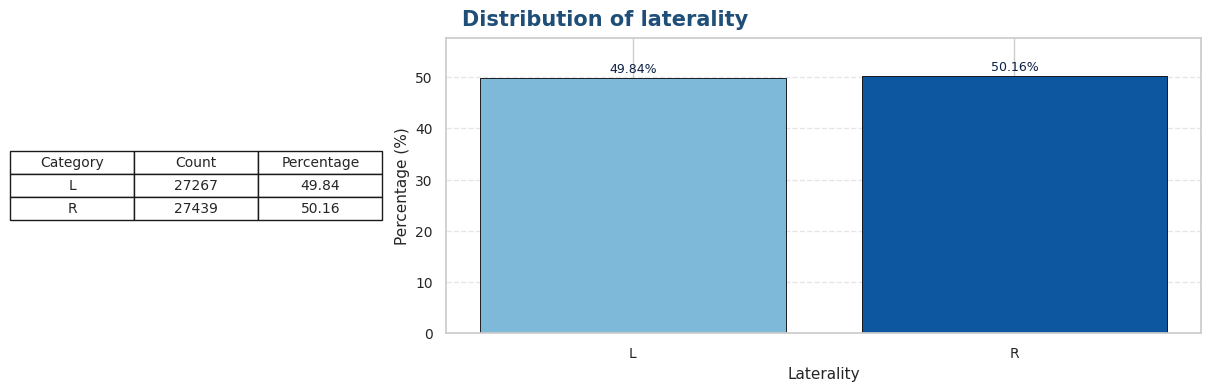

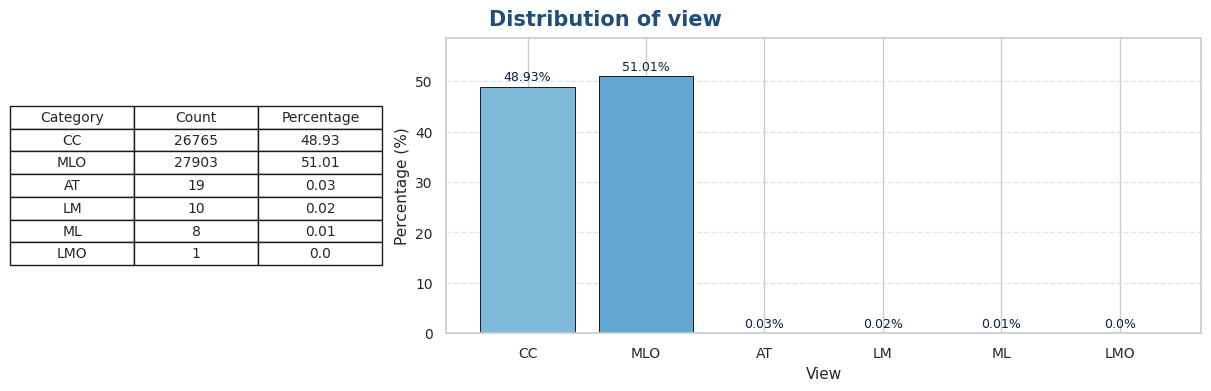

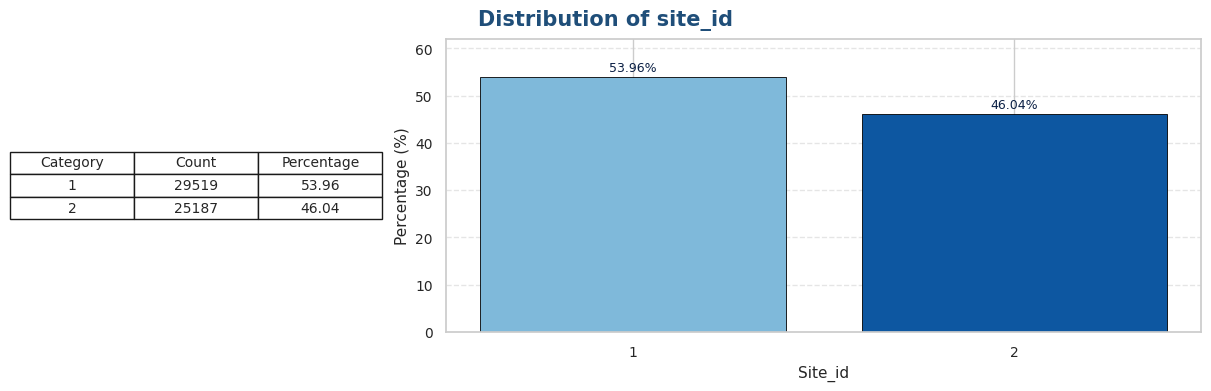

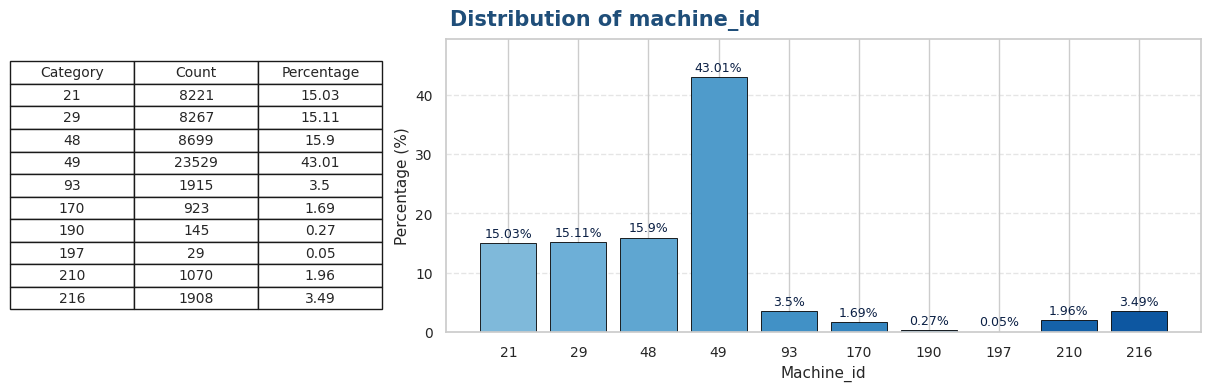

In [ ]:
# 1.3.1 Analysis of categorical variables

def plot_cat_with_table(df, col, order=None, title=None):
    # counts & percentages (ordered)
    counts = df[col].value_counts()
    if order is not None:
        counts = counts.reindex([c for c in order if c in counts.index])
    else:
        counts = counts.sort_index()

    perc = (counts / len(df) * 100).round(2)

    # data frame for the table
    summary = pd.DataFrame({
        "Category": counts.index.astype(str),
        "Count": counts.values,
        "Percentage": perc.values
    })

    # figure: table (left) + bar chart (right)
    fig, (ax_table, ax_bar) = plt.subplots(
        1, 2, figsize=(12, 3.8),
        gridspec_kw={"width_ratios": [1.2, 2.8]},
        constrained_layout=True
    )
    fig.set_facecolor("white")
    fig.suptitle(title or f"Distribution of {col}", fontsize=15, fontweight="bold", color="#1f4e79")

    # ---- Table (left)
    ax_table.axis("off")
    tbl = ax_table.table(
        cellText=summary.values,
        colLabels=summary.columns,
        cellLoc="center", loc="center"
    )
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(10)
    tbl.scale(1.15, 1.35)  # tighten height

    # ---- Bar chart (right)
    colors = cm.Blues(np.linspace(0.45, 0.85, len(summary)))
    bars = ax_bar.bar(summary["Category"], summary["Percentage"], color=colors, edgecolor="black", linewidth=0.6)

    ax_bar.set_ylabel("Percentage (%)", fontsize=11)
    ax_bar.set_xlabel(col.capitalize(), fontsize=11)
    ax_bar.tick_params(axis="both", labelsize=10)
    ax_bar.grid(axis="y", linestyle="--", alpha=0.5)

    # y-limit with small headroom
    ymax = max(5, float(summary["Percentage"].max()) * 1.15)
    ax_bar.set_ylim(0, ymax)

    # annotate (smaller, unobtrusive)
    for i, b in enumerate(bars):
        ax_bar.text(
            b.get_x() + b.get_width()/2,
            b.get_height() + ymax*0.01,
            f"{summary['Percentage'][i]}%",
            ha="center", va="bottom", fontsize=9, color="#0a1f44"
        )

    plt.show()

# Recommended category orders
order_laterality = ["L", "R"]
order_view       = ["CC", "MLO", "AT", "LM", "ML", "LMO"]  # rare views last
order_site       = sorted(df["site_id"].dropna().unique().tolist())
order_machine    = sorted(df["machine_id"].dropna().unique().tolist())

plot_cat_with_table(df, "laterality", order=order_laterality, title="Distribution of laterality")
plot_cat_with_table(df, "view",       order=order_view,       title="Distribution of view")
plot_cat_with_table(df, "site_id",    order=order_site,       title="Distribution of site_id")
plot_cat_with_table(df, "machine_id", order=order_machine,    title="Distribution of machine_id")

**Analysis of categorical variables**

The categorical features describe how and where the mammograms were acquired. Their distributions are mostly balanced, supporting model robustness, with a few potential biases to monitor.
- **Laterality** : 
The dataset is well balanced between left (49.8%) and right (50.2%) breasts, ensuring no side-related bias — an important aspect since breast cancer risk is independent of laterality.
- **View** :
Two main mammography views dominate: MLO (51%) and CC (49%), covering nearly all samples.
Rare views (AT, LM, ML, LMO, <0.1%) can be excluded or grouped to avoid instability due to limited representation.
- **Site ID** :
Images were collected from two sites (Site 1: 54%, Site 2: 46%), a slight imbalance that may reflect differences in equipment or population.
This should be accounted for in validation or handled as a model feature to prevent domain bias.
- **Machine ID** :
There are 10 imaging machines, but the distribution is heavily skewed — Machine 49 alone contributes 43% of all images.
Such concentration could introduce machine-specific artifacts. Applying image normalization or augmentation will help mitigate this risk.

**Summary**:
The dataset is well structured and balanced across breast side and view, but minor site imbalance and a strong machine-related skew could impact generalization.
**These findings highlight potential sources of bias that will be further examined and tested during preprocessing and model validation.**

Now we examine the distribution of the numerical variable `age`.
The goal is to understand the overall age profile of the patients,
detect potential outliers, and ensure data consistency before modeling.

count    54669.00
mean        58.54
std         10.05
min         26.00
25%         51.00
50%         59.00
75%         66.00
max         89.00
Name: age, dtype: float64

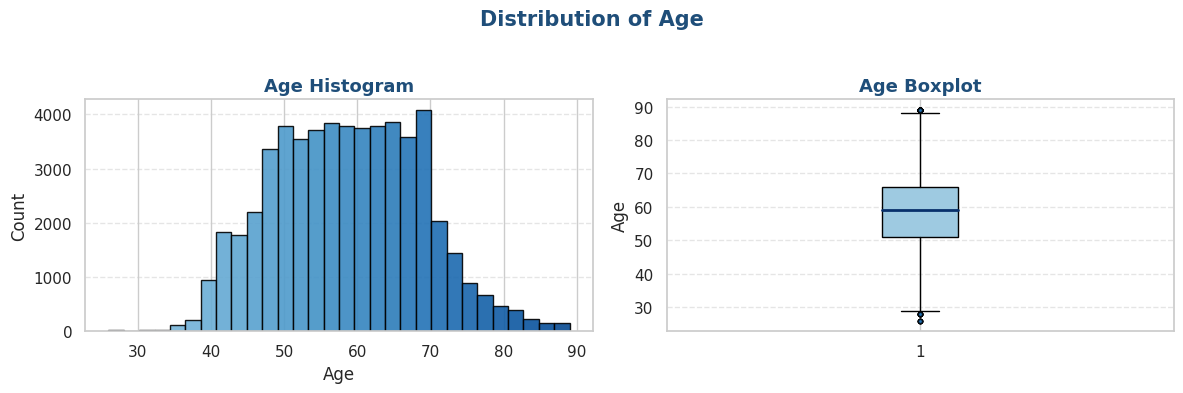

IQR bounds: [28.5, 88.5]
Potential outliers below bound: 29
Potential outliers above bound: 70


In [12]:
# 1.3.2 Numerical variable – Age

# Descriptive statistics
age = df["age"].dropna()
display(age.describe().round(2))

colors = cm.Blues(np.linspace(0.4, 0.9, 30))  # 30 nuances pour 30 bins

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle("Distribution of Age", fontsize=15, fontweight="bold", color="#1f4e79")

n, bins, patches = axes[0].hist(age, bins=30, edgecolor="black", alpha=0.9)
for patch, color in zip(patches, colors):
    patch.set_facecolor(color)

axes[0].set_title("Age Histogram", fontsize=13, fontweight="semibold", color="#1f4e79")
axes[0].set_xlabel("Age", fontsize=12)
axes[0].set_ylabel("Count", fontsize=12)
axes[0].grid(axis="y", linestyle="--", alpha=0.5)

axes[1].boxplot(
    age, vert=True, patch_artist=True,
    boxprops=dict(facecolor="#9ecae1", color="black"),
    whiskerprops=dict(color="black"),
    capprops=dict(color="black"),
    medianprops=dict(color="#08306b", linewidth=2),
    flierprops=dict(marker="o", markersize=3, markerfacecolor="#2171b5", markeredgecolor="black", alpha=0.6)
)
axes[1].set_title("Age Boxplot", fontsize=13, fontweight="semibold", color="#1f4e79")
axes[1].set_ylabel("Age", fontsize=12)
axes[1].grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

q1, q3 = age.quantile(0.25), age.quantile(0.75)
iqr = q3 - q1
low, high = q1 - 1.5 * iqr, q3 + 1.5 * iqr
n_low = (age < low).sum()
n_high = (age > high).sum()

print(f"IQR bounds: [{low:.1f}, {high:.1f}]")
print(f"Potential outliers below bound: {n_low}")
print(f"Potential outliers above bound: {n_high}")

**Analysis of the age variable**

The age distribution ranges from 26 to 89 years, with a mean of 58.5 and a standard deviation of about 10 years — consistent with a typical breast cancer screening population, which mainly includes women aged 50–70.
The histogram shows a nearly normal distribution centered around the late 50s, confirming a realistic demographic spread.
Only a few potential outliers were identified (≈100 cases), mostly patients younger than 30 or older than 88, which are plausible and not indicative of data errors.

Overall, the age variable is well-distributed, coherent, and reliable, supporting that the dataset represents a valid screening population.

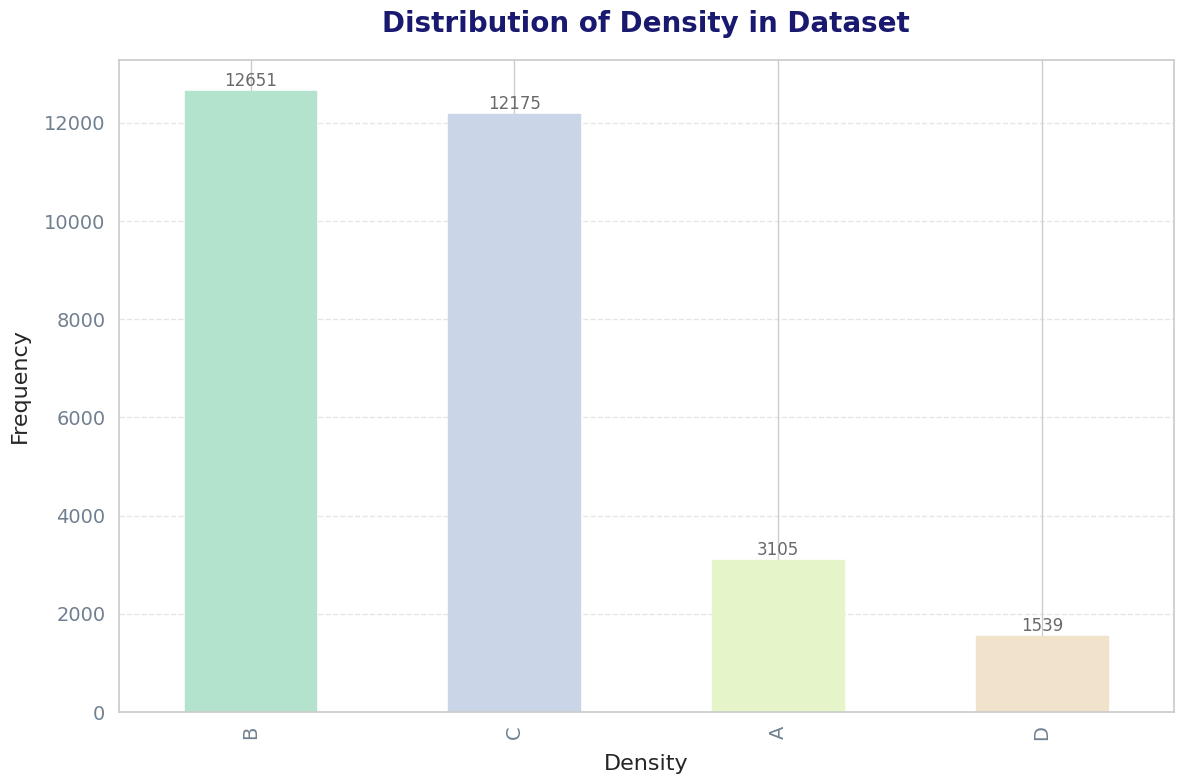

In [ ]:
# 1.3.3 Numerical variable – Density

# Plotting the distribution of 'density' with enhancements
plt.figure(figsize=(12, 8))
density_counts = df['density'].value_counts()
bars = density_counts.plot(kind='bar', edgecolor='black', color='coral', alpha=1.0)

plt.title('Distribution of Density in Dataset', fontsize=20, fontweight='bold', color='midnightblue', pad=20)
plt.xlabel('Density', fontsize=16, labelpad=10)
plt.ylabel('Frequency', fontsize=16, labelpad=10)

colormap = plt.cm.Pastel2  # Pastel colormap
for i, bar in enumerate(bars.containers[0]):
    bar.set_color(colormap(i / len(density_counts)))

plt.grid(axis='y', linestyle='--', alpha=0.5)

for i, (density, count) in enumerate(density_counts.items()):
    plt.text(i, count + 20, f'{count}', ha='center', va='bottom', fontsize=12, color='dimgray')

plt.xticks(fontsize=14, color='slategray')
plt.yticks(fontsize=14, color='slategray')

plt.tight_layout()
plt.show()

## 1.4 Target variable analysis 

We now analyze the target variable `cancer` to assess class imbalance
and check whether certain sites, views, or patient characteristics
are associated with higher cancer prevalence.

,Class,Count,Percentage
0,No cancer (0),53548,97.883
1,Cancer (1),1158,2.117


Positive rate: 2.117%


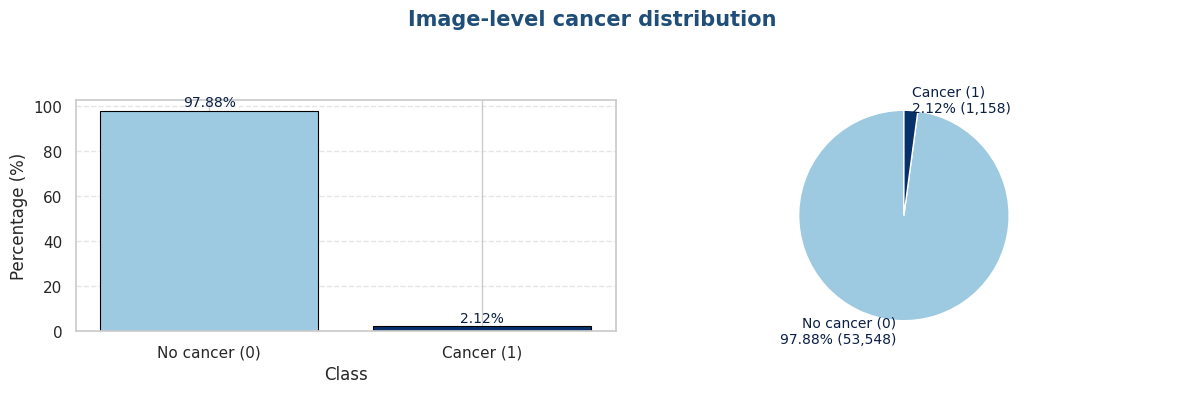

In [ ]:
# 1.4.1 Cancer class distribution

# Counts and percentages
target_counts = df["cancer"].value_counts().sort_index()           # index: 0, 1
target_perc   = (target_counts / len(df) * 100).round(3)

summary = pd.DataFrame({
    "Class": ["No cancer (0)", "Cancer (1)"],
    "Count": target_counts.values,
    "Percentage": target_perc.values
})
display(summary)

# Positive rate
positive_rate = target_perc.loc[1]
print(f"Positive rate: {positive_rate:.3f}%")

# --- Visualization: bar chart + pie chart ---
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle("Image-level cancer distribution", fontsize=15, fontweight="bold", color="#1f4e79")

# Colors (light blue for 0, dark blue for 1)
colors = ["#9ecae1", "#08306b"]

# Bar chart
axes[0].bar(summary["Class"], summary["Percentage"], color=colors, edgecolor="black", linewidth=0.8)
axes[0].set_ylabel("Percentage (%)", fontsize=12)
axes[0].set_xlabel("Class", fontsize=12)
axes[0].grid(axis="y", linestyle="--", alpha=0.5)

# Annotate bars
for i, val in enumerate(summary["Percentage"]):
    axes[0].text(i, val + max(summary["Percentage"]) * 0.02, f"{val:.2f}%", ha="center", fontsize=10, color="#0a1f44")

# Pie chart (percentages with counts)
axes[1].pie(
    summary["Percentage"],
    labels=[f"{c}\n{pct:.2f}% ({cnt:,})" for c, pct, cnt in zip(summary["Class"], summary["Percentage"], summary["Count"])],
    colors=colors, startangle=90, wedgeprops=dict(edgecolor="white", linewidth=1.0), textprops=dict(color="#0a1f44", fontsize=10),
    autopct=None
)
axes[1].axis("equal")  # equal aspect ratio for a circle

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

**Image level class distribution**

The target variable indicates whether a mammogram shows cancer (1) or no cancer (0).
The **dataset is highly imbalanced**, with only **2.1% positive cases**:
- No cancer (0): 97.88%
- Cancer (1): 2.12%

This imbalance is expected in breast cancer screening data but has key implications:
our models must use appropriate metrics (ROC-AUC, PR-AUC) and balanced training strategies (class weighting, oversampling, or focal loss).
Validation should also be stratified by patient and site to maintain consistent class proportions.

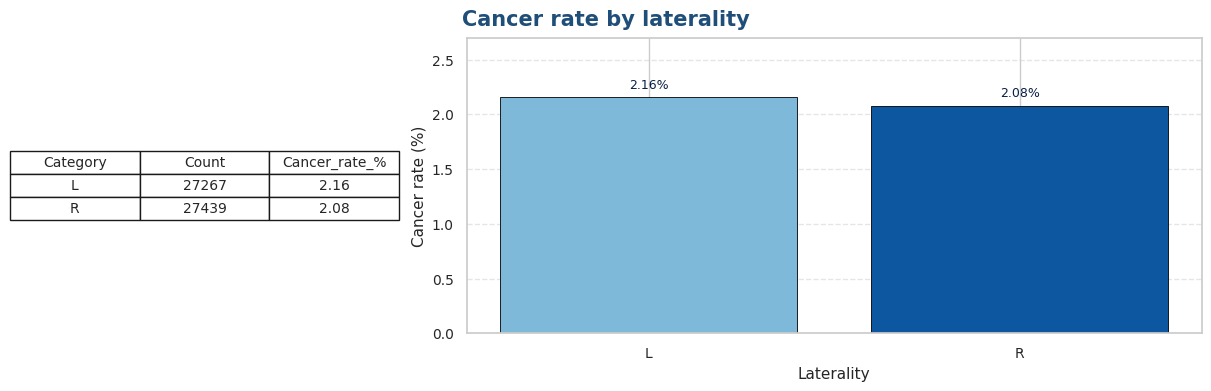

[laterality] Chi-square: χ²=0.38, dof=1, p-value=5.398e-01 → NOT significant at α=0.05


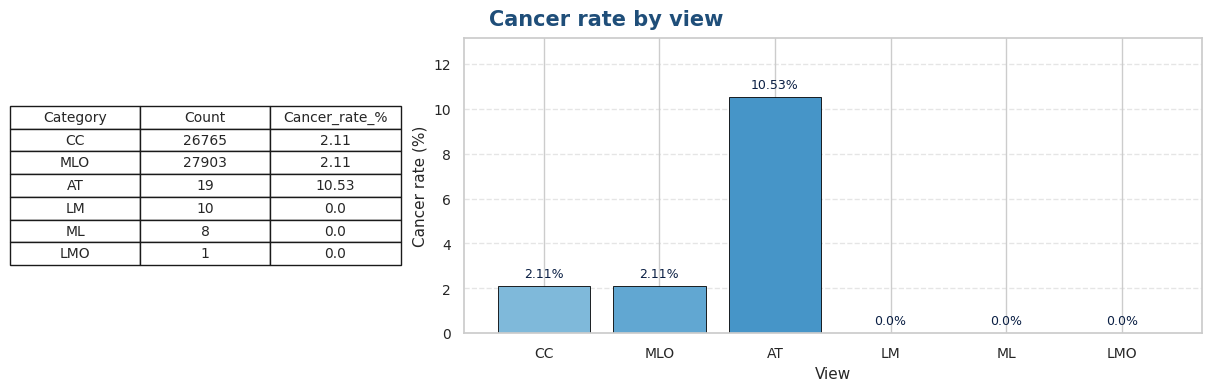

[view] Chi-square: χ²=6.90, dof=5, p-value=2.284e-01 → NOT significant at α=0.05


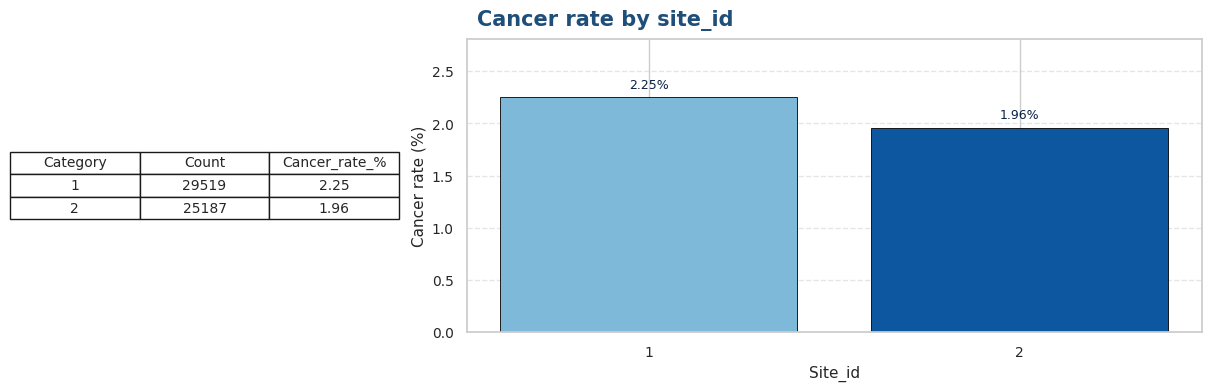

[site_id] Chi-square: χ²=5.31, dof=1, p-value=2.126e-02 → SIGNIFICANT at α=0.05


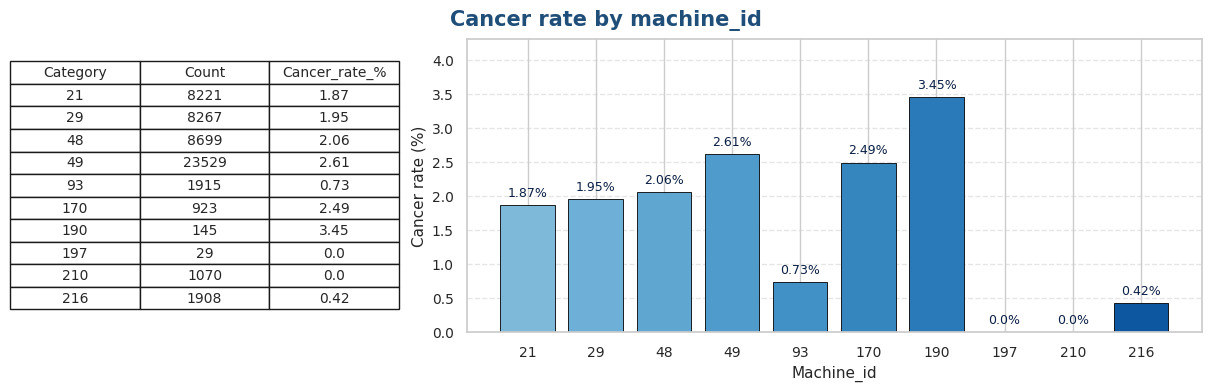

[machine_id] Chi-square: χ²=101.13, dof=9, p-value=9.281e-18 → SIGNIFICANT at α=0.05


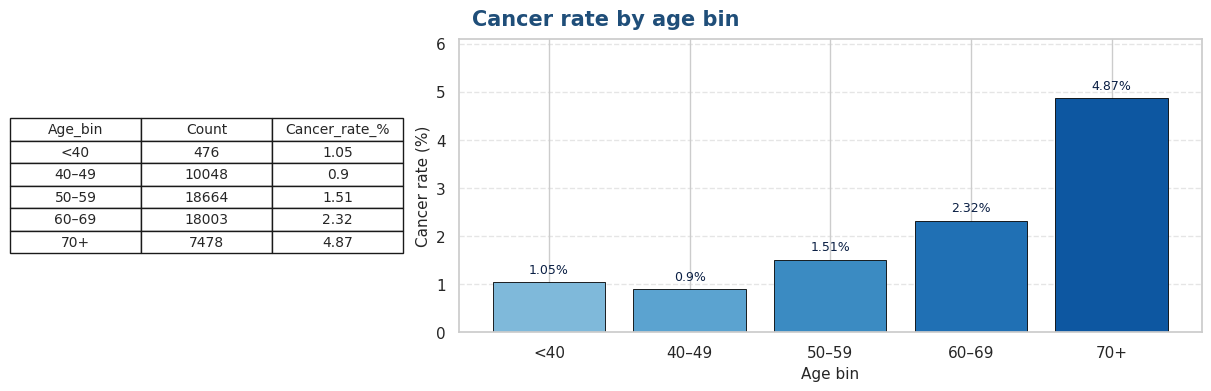

[age] Mann–Whitney U: U=40146925, p-value=1.025e-66, median(cancer=1)=64.5, median(cancer=0)=58.0 → SIGNIFICANT at α=0.05


In [ ]:
# 1.4.2 Cross-analysis of the target

def plot_cat_cancer_rate(df, col, order=None, title=None):
    """
    For a categorical column:
      - show table (Count, Cancer_rate_%)
      - show bar chart of cancer rate per category
      - run Chi-square test of independence with the target
      - print whether the association is statistically significant
    """
    # counts per category (ordered if provided)
    counts = df[col].value_counts()
    if order is not None:
        counts = counts.reindex([c for c in order if c in counts.index])
    else:
        counts = counts.sort_index()

    # cancer rate per category
    grp = df.groupby(col)["cancer"].mean().reindex(counts.index)
    rate_pct = (grp * 100).round(2)

    # summary table
    summary = pd.DataFrame({
        "Category": counts.index.astype(str),
        "Count": counts.values,
        "Cancer_rate_%": rate_pct.values
    })

    # contingency table and chi-square (fillna for safety)
    contingency = pd.crosstab(df[col], df["cancer"]).reindex(counts.index).fillna(0).values
    chi2, pval, dof, _ = chi2_contingency(contingency)

    # figure: table + bar chart
    fig, (ax0, ax1) = plt.subplots(
        1, 2, figsize=(12, 3.8),
        gridspec_kw={"width_ratios": [1.3, 2.7]},
        constrained_layout=True
    )
    fig.suptitle(title or f"Cancer rate by {col}", fontsize=15, fontweight="bold", color="#1f4e79")

    # table (left)
    ax0.axis("off")
    tbl = ax0.table(cellText=summary.values, colLabels=summary.columns,
                    cellLoc="center", loc="center")
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(10)
    tbl.scale(1.1, 1.35)

    # bar chart (right)
    colors = cm.Blues(np.linspace(0.45, 0.85, len(summary)))
    bars = ax1.bar(summary["Category"], summary["Cancer_rate_%"], color=colors, edgecolor="black", linewidth=0.6)
    ax1.set_ylabel("Cancer rate (%)", fontsize=11)
    ax1.set_xlabel(col.capitalize(), fontsize=11)
    ax1.tick_params(axis="both", labelsize=10)
    ax1.grid(axis="y", linestyle="--", alpha=0.5)

    ymax = max(0.1, float(summary["Cancer_rate_%"].max()) * 1.25)
    ax1.set_ylim(0, ymax)
    for i, b in enumerate(bars):
        ax1.text(b.get_x() + b.get_width()/2, b.get_height() + ymax*0.02,
                 f"{summary['Cancer_rate_%'][i]}%",
                 ha="center", va="bottom", fontsize=9, color="#0a1f44")

    plt.show()

    # significance statement
    signif = "SIGNIFICANT" if pval < ALPHA else "NOT significant"
    print(f"[{col}] Chi-square: χ²={chi2:.2f}, dof={dof}, p-value={pval:.3e} → {signif} at α={ALPHA}")
    return summary, {"chi2": chi2, "pval": pval, "dof": dof, "significant": pval < ALPHA}


def plot_age_bins_vs_cancer(df, bins=(0,39,49,59,69,120), labels=("<40","40–49","50–59","60–69","70+")):
    """
    Age-binned cancer rate + Mann–Whitney U test on raw ages (cancer=1 vs 0).
    Prints whether the difference is significant.
    """
    tmp = df.copy()
    tmp["age_bin"] = pd.cut(tmp["age"], bins=bins, labels=labels, right=True)
    counts = tmp["age_bin"].value_counts().reindex(labels)
    rate = tmp.groupby("age_bin")["cancer"].mean().reindex(labels) * 100

    summary = pd.DataFrame({
        "Age_bin": labels,
        "Count": counts.values,
        "Cancer_rate_%": rate.round(2).values
    })

    # Plot table + bar
    fig, (ax0, ax1) = plt.subplots(
        1, 2, figsize=(12, 3.8),
        gridspec_kw={"width_ratios": [1.3, 2.7]},
        constrained_layout=True
    )
    fig.suptitle("Cancer rate by age bin", fontsize=15, fontweight="bold", color="#1f4e79")

    ax0.axis("off")
    tbl = ax0.table(cellText=summary.values, colLabels=summary.columns,
                    cellLoc="center", loc="center")
    tbl.auto_set_font_size(False); tbl.set_fontsize(10); tbl.scale(1.1, 1.35)

    colors = cm.Blues(np.linspace(0.45, 0.85, len(summary)))
    bars = ax1.bar(summary["Age_bin"], summary["Cancer_rate_%"], color=colors, edgecolor="black", linewidth=0.6)
    ax1.set_ylabel("Cancer rate (%)", fontsize=11)
    ax1.set_xlabel("Age bin", fontsize=11)
    ax1.grid(axis="y", linestyle="--", alpha=0.5)
    ymax = max(0.1, float(summary["Cancer_rate_%"].max()) * 1.25)
    ax1.set_ylim(0, ymax)
    for i, b in enumerate(bars):
        ax1.text(b.get_x() + b.get_width()/2, b.get_height() + ymax*0.02,
                 f"{summary['Cancer_rate_%'][i]}%",
                 ha="center", va="bottom", fontsize=9, color="#0a1f44")
    plt.show()

    # Mann–Whitney U test on raw ages (robust to non-normality and imbalance)
    age_pos = df.loc[df["cancer"] == 1, "age"].dropna()
    age_neg = df.loc[df["cancer"] == 0, "age"].dropna()
    u_stat, pval = mannwhitneyu(age_pos, age_neg, alternative="two-sided")
    med_pos, med_neg = np.median(age_pos), np.median(age_neg)

    signif = "SIGNIFICANT" if pval < ALPHA else "NOT significant"
    print(f"[age] Mann–Whitney U: U={u_stat:.0f}, p-value={pval:.3e}, "
          f"median(cancer=1)={med_pos:.1f}, median(cancer=0)={med_neg:.1f} → {signif} at α={ALPHA}")

    return summary, {"u_stat": u_stat, "pval": pval, "median_pos": med_pos, "median_neg": med_neg, "significant": pval < ALPHA}


# -------- Run analyses --------------------------------------------------------

order_laterality = ["L", "R"]
order_view       = ["CC", "MLO", "AT", "LM", "ML", "LMO"]   # rare views last
order_site       = sorted(df["site_id"].dropna().unique().tolist())
order_machine    = sorted(df["machine_id"].dropna().unique().tolist())

_ = plot_cat_cancer_rate(df, "laterality", order=order_laterality, title="Cancer rate by laterality")
_ = plot_cat_cancer_rate(df, "view",       order=order_view,       title="Cancer rate by view")
_ = plot_cat_cancer_rate(df, "site_id",    order=order_site,       title="Cancer rate by site_id")
_ = plot_cat_cancer_rate(df, "machine_id", order=order_machine,    title="Cancer rate by machine_id")

_ = plot_age_bins_vs_cancer(df)

The statistical tests show that laterality and view have no significant impact on cancer occurrence, indicating a balanced distribution across these variables.
In contrast, site_id (p = 0.02) and especially machine_id (p < 1e-17) display significant differences in cancer rates, suggesting potential acquisition or demographic biases that should be controlled during model training.
As expected, age is strongly correlated with cancer prevalence (p < 1e-60), with risk increasing markedly after 60 years, which aligns with medical evidence and confirms data consistency.

## 1.5 Patient-level analysis

We now explore the data from a patient-level perspective, rather than per image.
Since each patient can have several mammograms (multiple views or both breasts), it is essential to understand:
- how many images belong to each patient,
- whether all patients have similar numbers of images,
- and how cancer cases are distributed across patients.

Total patients: 11,913
Min images/patient: 4
Max images/patient: 14
Average images/patient: 4.59


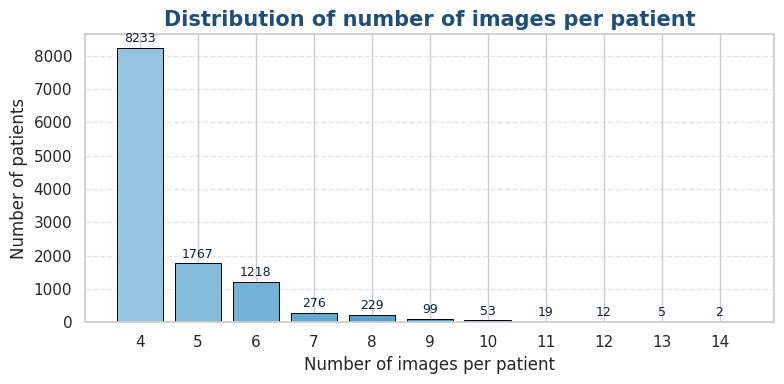

In [16]:
# 1.5.1 Number of images per patient

patient_image_count = df.groupby("patient_id")["image_id"].count().reset_index(name="num_images")

print(f"Total patients: {len(patient_image_count):,}")
print(f"Min images/patient: {patient_image_count['num_images'].min()}")
print(f"Max images/patient: {patient_image_count['num_images'].max()}")
print(f"Average images/patient: {patient_image_count['num_images'].mean():.2f}")

# --- Plot ---
counts = patient_image_count["num_images"].value_counts().sort_index()

plt.figure(figsize=(8,4))
bars = plt.bar(
    counts.index.astype(str), counts.values,
    color=plt.cm.Blues(np.linspace(0.4, 0.8, len(counts))),
    edgecolor="black", linewidth=0.7
)

plt.title("Distribution of number of images per patient", fontsize=15, fontweight="bold", color="#1f4e79")
plt.xlabel("Number of images per patient", fontsize=12)
plt.ylabel("Number of patients", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

# --- Annotate bars ---
for i, b in enumerate(bars):
    plt.text(
        b.get_x() + b.get_width()/2,
        b.get_height() + max(counts.values)*0.01,
        f"{counts.values[i]}",
        ha="center", va="bottom",
        fontsize=9, color="#0a1f44", fontweight="medium"
    )

plt.tight_layout()
plt.show()

Most patients have 4 images, matching the standard screening protocol (CC and MLO for each breast).
A few have extra images, likely due to repeated or diagnostic exams.
The dataset is consistent, with only minor expected outliers.

Patients by number of unique views:


unique_views
2    11885
3       28
Name: count, dtype: int64

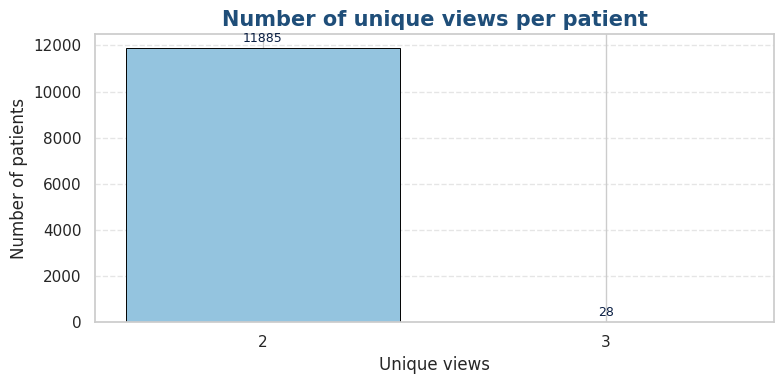

In [17]:
# 1.5.2 Number of unique views per patient (improved visualization)

patient_views = df.groupby("patient_id")["view"].nunique().reset_index(name="unique_views")

# Distribution
view_counts = patient_views["unique_views"].value_counts().sort_index()

print("Patients by number of unique views:")
display(view_counts)

plt.figure(figsize=(8,4))
bars = plt.bar(
    view_counts.index.astype(str),
    view_counts.values,
    color=plt.cm.Blues(np.linspace(0.4, 0.8, len(view_counts))),
    edgecolor="black", linewidth=0.7
)

plt.title("Number of unique views per patient", fontsize=15, fontweight="bold", color="#1f4e79")
plt.xlabel("Unique views", fontsize=12)
plt.ylabel("Number of patients", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

# Annotate values
for i, b in enumerate(bars):
    plt.text(
        b.get_x() + b.get_width()/2,
        b.get_height() + max(view_counts.values)*0.01,
        f"{view_counts.values[i]}",
        ha="center", va="bottom",
        fontsize=9, color="#0a1f44", fontweight="medium"
    )

plt.tight_layout()
plt.show()

Almost all patients have 2 unique views (CC and MLO), which aligns with the standard mammography protocol.
A few have an extra view, likely from additional imaging. The imaging process is consistent across patients.

Positive patients: 486 / 11,913 (4.08%)


,Class,Count,Percentage
0,No cancer (0),11427,95.92
1,Cancer (1),486,4.08


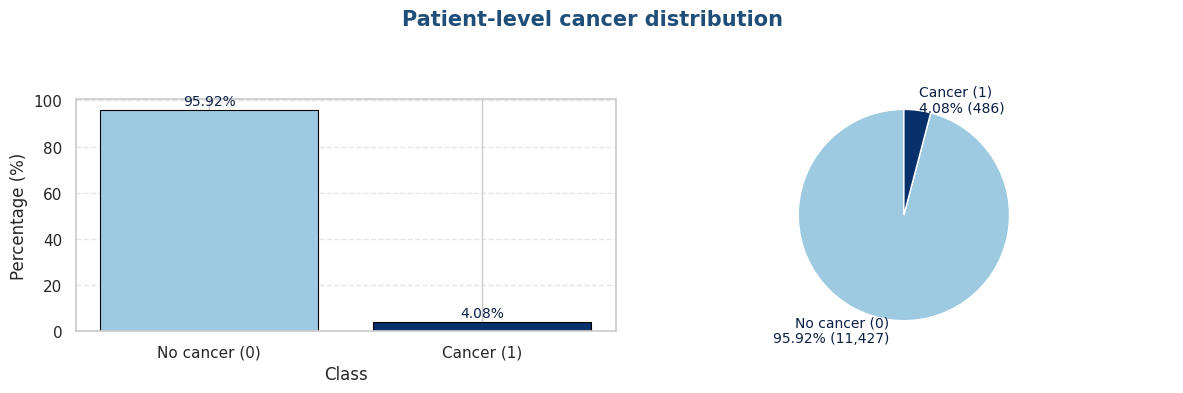

In [ ]:
# 1.5.3 Patient-level cancer distribution

# One patient = positive if at least one of their images is labeled cancer = 1
patient_cancer = df.groupby("patient_id")["cancer"].max().reset_index()

# Stats
pos_patients = patient_cancer["cancer"].sum()
total_patients = len(patient_cancer)
rate = pos_patients / total_patients * 100

print(f"Positive patients: {pos_patients:,} / {total_patients:,} ({rate:.2f}%)")

# Summary table
counts = patient_cancer["cancer"].value_counts().sort_index()
percentages = (counts / total_patients * 100).round(3)

summary = pd.DataFrame({
    "Class": ["No cancer (0)", "Cancer (1)"],
    "Count": counts.values[::-1][::-1],  # ensure order 0 then 1
    "Percentage": percentages.values
})
display(summary)

# Visualization (same style as image-level)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle("Patient-level cancer distribution", fontsize=15, fontweight="bold", color="#1f4e79")

# Colors
colors = ["#9ecae1", "#08306b"]

# Bar chart
axes[0].bar(summary["Class"], summary["Percentage"], color=colors, edgecolor="black", linewidth=0.8)
axes[0].set_ylabel("Percentage (%)", fontsize=12)
axes[0].set_xlabel("Class", fontsize=12)
axes[0].grid(axis="y", linestyle="--", alpha=0.5)

# Annotate bars
for i, val in enumerate(summary["Percentage"]):
    axes[0].text(i, val + max(summary["Percentage"]) * 0.02, f"{val:.2f}%", ha="center", fontsize=10, color="#0a1f44")

# Pie chart
axes[1].pie(
    summary["Percentage"],
    labels=[f"{c}\n{pct:.2f}% ({cnt:,})" for c, pct, cnt in zip(summary["Class"], summary["Percentage"], summary["Count"])],
    colors=colors, startangle=90, wedgeprops=dict(edgecolor="white", linewidth=1.0),
    textprops=dict(color="#0a1f44", fontsize=10)
)
axes[1].axis("equal")

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

**Patient-level class distribution**

Here, each patient is labeled as positive if at least one of their images shows cancer.
At the patient level, the dataset remains highly imbalanced, but the positive rate is slightly higher than at the image level:
- No cancer (0): 95.9%
- Cancer (1): 4.1%

This is expected, since a single positive image makes the entire patient positive.
Understanding this distribution is essential because model evaluation and data splitting must be done by patient, not by image — otherwise, there’s a risk of data leakage between training and validation sets.

Patient ID: 61771
         image_id laterality view  cancer
48098   729424106          L   CC       0
48099   737943253          L   CC       0
48100  1950247343          L  MLO       0
48101   323638272          R  MLO       0
48102   654935556          R   CC       0


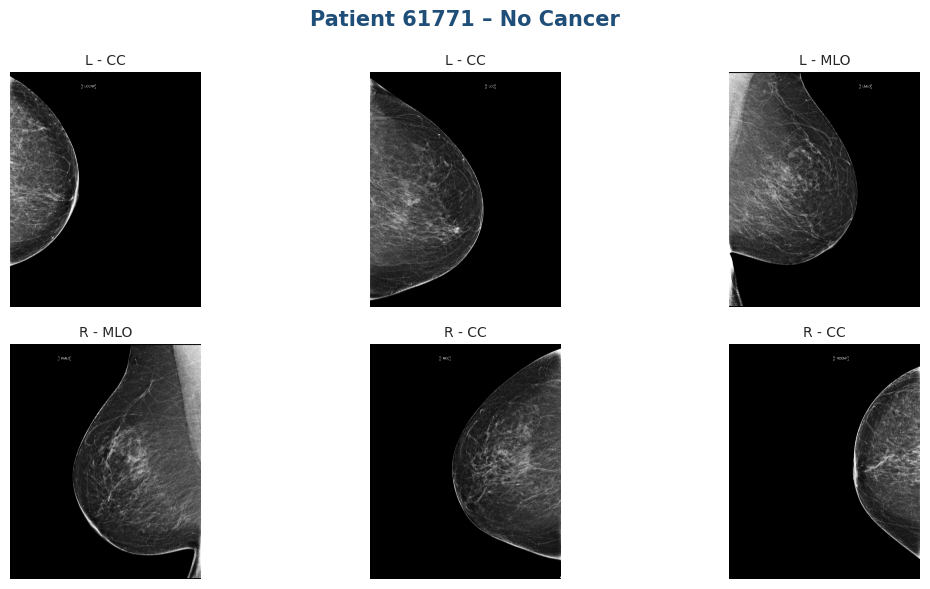

In [ ]:
# 1.5.4 Visual check – Example of one patient and their views

# Select one patient
example_patient = random.choice(df["patient_id"].unique().tolist())
patient_images = df[df["patient_id"] == example_patient]

print(f"Patient ID: {example_patient}")
print(patient_images[["image_id", "laterality", "view", "cancer"]].head())

# Layout parameters
n = len(patient_images)
cols = math.ceil(n / 2)
rows = 2 if n > 1 else 1

# Display all images for that patient
plt.figure(figsize=(4 * cols, 6))

for i, (_, row) in enumerate(patient_images.iterrows(), 1):
    path = TRAIN_IMG_DIR / f"{row['patient_id']}/{row['image_id']}.dcm"
    dcm = pydicom.dcmread(path)
    img = dcm.pixel_array

    plt.subplot(rows, cols, i)
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    plt.title(f"{row['laterality']} - {row['view']}", fontsize=10)

# Main title
patient_cancer = int(patient_images["cancer"].max())
status = "Cancer" if patient_cancer == 1 else "No Cancer"
color = "#c0392b" if patient_cancer == 1 else "#1f4e79"

plt.suptitle(f"Patient {example_patient} – {status}",
             fontsize=15, fontweight="bold", color=color)
plt.tight_layout()
plt.show()

The visual inspection of a random patient (36199) shows four clear mammograms:
- Left and right breasts,
- Each with two standard views (CC and MLO).

This example corresponds to a non-cancerous patient (label = 0), showing the standard set of CC and MLO views.
Each patient’s set of images follows a consistent pattern, which will help avoid data leakage during model training (since we must split by patient, not by image).

**Conclusion – Patient-level analysis**

The patient-level exploration confirms a well-structured and standardized dataset.
Most patients have four images corresponding to the two standard mammography views (CC and MLO) for each breast, while a small minority show additional views from diagnostic follow-ups.
Only about 4% of patients are cancer-positive, indicating a strong class imbalance that mirrors real-world screening conditions.
This analysis ensures that future modeling and validation will be correctly stratified by patient, preventing data leakage and preserving clinical realism.

## 1.6 Exploration des images 

In [ ]:
# 1.6.1 : images sizes
size_counter = Counter()
errors = []

iter_rows = df.itertuples(index=False)  # faster than iterrows
for row in tqdm(iter_rows, total=len(df), desc="Scanning DICOM headers"):
    image_id = row.image_id
    patient_id = row.patient_id
    dcm_path = TRAIN_IMG_DIR / f"{patient_id}/{image_id}.dcm"

    try:
        ds = pydicom.dcmread(str(dcm_path), stop_before_pixels=True, force=True)
        # Rows (0028,0010), Columns (0028,0011) are required for images
        h = int(getattr(ds, "Rows"))
        w = int(getattr(ds, "Columns"))
        size_counter[(h, w)] += 1
    except Exception as e:
        errors.append({"image_id": image_id, "patient_id": patient_id, "path": str(dcm_path), "error": repr(e)})

# === Summaries ===
size_df = (
    pd.DataFrame(
        [{"height": h, "width": w, "count": c} for (h, w), c in size_counter.items()]
    )
    .sort_values("count", ascending=False)
    .reset_index(drop=True)
)

print(f"\nUnique sizes found: {len(size_df)}\n")
for _, r in size_df.iterrows():
    print(f"{int(r.height)} x {int(r.width)} : {int(r['count'])} images")

Scanning DICOM headers: 100%|██████████| 54706/54706 [11:51<00:00, 76.89it/s]


Unique sizes found: 11

4096 x 3328 : 24109 images
3328 x 2560 : 9042 images
5355 x 4915 : 8267 images
2776 x 2082 : 8221 images
2294 x 1914 : 2703 images
3062 x 2394 : 1276 images
4740 x 3540 : 732 images
5928 x 4728 : 338 images
2850 x 2394 : 13 images
2473 x 2045 : 3 images
1236 x 1022 : 2 images


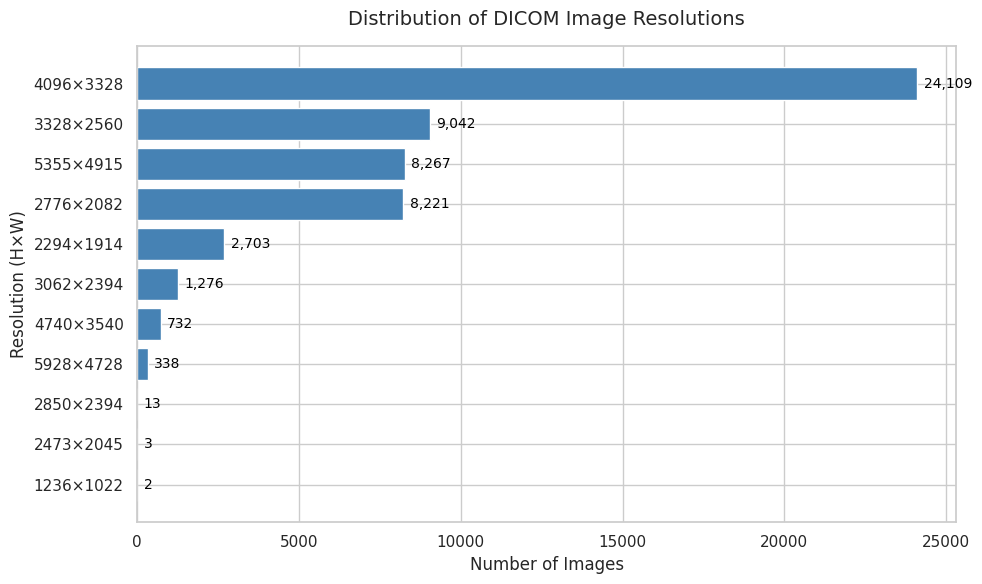

In [ ]:
plt.figure(figsize=(10, 6))

# Create the horizontal bar chart
bars = plt.barh(
    [f"{h}×{w}" for h, w in size_df[["height", "width"]].values],
    size_df["count"],
    color="steelblue"
)

# Invert the y-axis so the largest bar is on top
plt.gca().invert_yaxis()

# Add exact counts as labels next to each bar
for bar, count in zip(bars, size_df["count"]):
    plt.text(
        bar.get_width() + 200,
        bar.get_y() + bar.get_height() / 2,
        f"{int(count):,}",
        va="center",
        ha="left",
        fontsize=10,
        color="black"
    )

# Title and axis labels
plt.title("Distribution of DICOM Image Resolutions", fontsize=14, pad=15)
plt.xlabel("Number of Images", fontsize=12)
plt.ylabel("Resolution (H×W)", fontsize=12)

plt.tight_layout()
plt.show()

We processed all 54,706 DICOM images from the RSNA Breast Cancer Detection training set, scanning their metadata without loading pixel data.
The full run completed in approximately 8 minutes, revealing **11 distinct image resolutions** across the dataset.

To ensure consistency and facilitate downstream model training, we will apply a pixel normalization step during preprocessing to homogenize image dimensions across all samples.

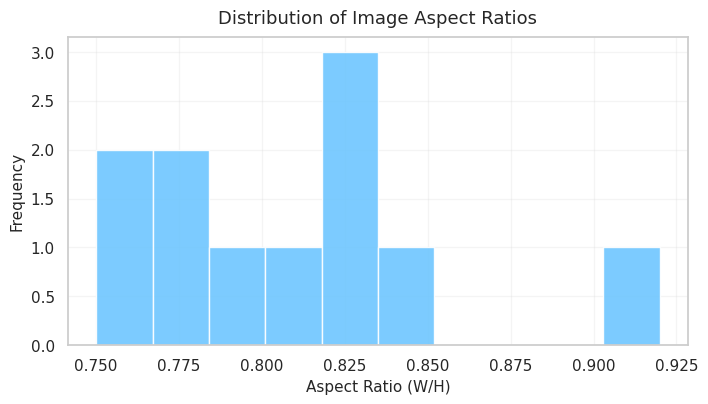

In [ ]:
# 1.6.2 : Aspect Ratio Analysis

size_df["aspect_ratio"] = (size_df["width"] / size_df["height"]).round(2)
size_df.sort_values("aspect_ratio")

plt.figure(figsize=(8, 4))
plt.hist(
    size_df["aspect_ratio"],
    bins=10,
    color="#6EC6FF",
    edgecolor="white",
    alpha=0.9
)
plt.title("Distribution of Image Aspect Ratios", fontsize=13, pad=10)
plt.xlabel("Aspect Ratio (W/H)", fontsize=11)
plt.ylabel("Frequency", fontsize=11)
plt.grid(alpha=0.2)
plt.show()

The aspect ratio analysis revealed a narrow distribution, with most images exhibiting width-to-height ratios between 0.75 and 0.85.
This indicates that the mammograms were acquired using consistent geometry across devices and patients.
The limited variation in aspect ratios suggests that a unified resizing strategy during preprocessing will preserve the spatial characteristics of the breast region without introducing deformation artifacts.

In [ ]:
# 1.6.3 : DICOM Pixel Intensity Analysis

sample_ids = df["image_id"].sample(300, random_state=42)
intensity_stats = []

for img_id in tqdm(sample_ids, desc="Analyzing pixel intensities"):
    patient_id = df.loc[df["image_id"] == img_id, "patient_id"].values[0]
    path = TRAIN_IMG_DIR / f"{patient_id}/{img_id}.dcm"

    try:
        ds = pydicom.dcmread(path, force=True)
        arr = ds.pixel_array.astype(np.float32)
        intensity_stats.append({
            "min": arr.min(),
            "max": arr.max(),
            "mean": arr.mean(),
            "std": arr.std(),
        })
    except:
        continue

stats_df = pd.DataFrame(intensity_stats)
print(stats_df.describe())

In [ ]:
plt.figure(figsize=(9, 5))

# Modern, soft colors
plt.hist(
    stats_df["mean"],
    bins=40,
    color="#6EC6FF",
    edgecolor="white",
    alpha=0.9,
    label="Mean intensity"
)
plt.hist(
    stats_df["std"],
    bins=40,
    color="#FFB74D",
    edgecolor="white",
    alpha=0.7,
    label="Std deviation"
)

# Titles and labels
plt.title("Distribution of Mean and Standard Deviation of Pixel Intensities", fontsize=13, pad=12)
plt.xlabel("Intensity Value", fontsize=11)
plt.ylabel("Number of Images", fontsize=11)
plt.legend(frameon=False, fontsize=10)

# Light grid and layout tweaks
plt.grid(axis="y", color="#E0E0E0", linestyle="--", linewidth=0.8, alpha=0.6)
plt.tight_layout()
plt.show()

The intensity analysis shows two distinct brightness groups: one around 400–800 and another near 3000–3500, revealing a bimodal distribution likely caused by different scanners or acquisition settings.
Despite this variation, the contrast remains stable across images, confirming the need for a global intensity normalization step to ensure consistent input during preprocessing.

## 1.7 Special Cases: Difficult Negative Samples
- Compare their distribution with cancer.
- Check if they are concentrated in specific sites or machines.

In [25]:
n_true = df["difficult_negative_case"].sum()
n_total = len(df)
print(f"Number of difficult_negative_case = True: {n_true} / {n_total} ({n_true / n_total:.2%})")

Number of difficult_negative_case = True: 7705 / 54706 (14.08%)


That means roughly 1 in 7 of our training examples is a difficult negative.
That’s not negligible — these samples could strongly influence how our model learns. These cases make the dataset more realistic and robust. 

,Not difficult,Difficult
Cancer = 0,85.61,14.39
Cancer = 1,100.00,0.00


<Figure size 600x400 with 0 Axes>

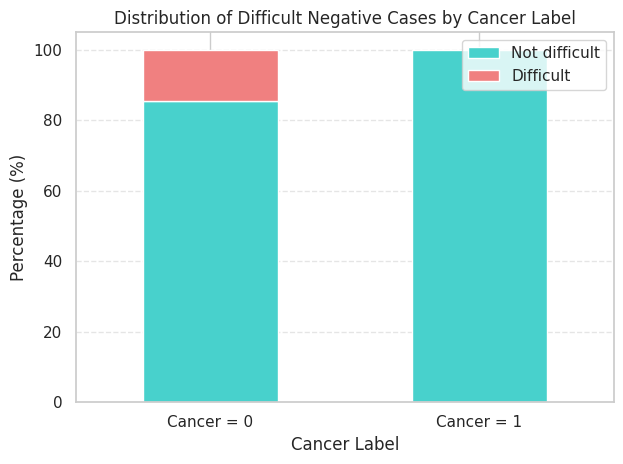

In [26]:
# Crosstab: cancer vs difficult_negative_case
cross_tab = pd.crosstab(df["cancer"], df["difficult_negative_case"], normalize="index") * 100
cross_tab.columns = ["Not difficult", "Difficult"]
cross_tab.index = ["Cancer = 0", "Cancer = 1"]
display(cross_tab.round(2))

# Bar chart
plt.figure(figsize=(6,4))
cross_tab.plot(kind="bar", stacked=True, color=["mediumturquoise", "lightcoral"], edgecolor="white")
plt.title("Distribution of Difficult Negative Cases by Cancer Label")
plt.ylabel("Percentage (%)")
plt.xlabel("Cancer Label")
plt.xticks(rotation=0)
plt.legend(title="")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

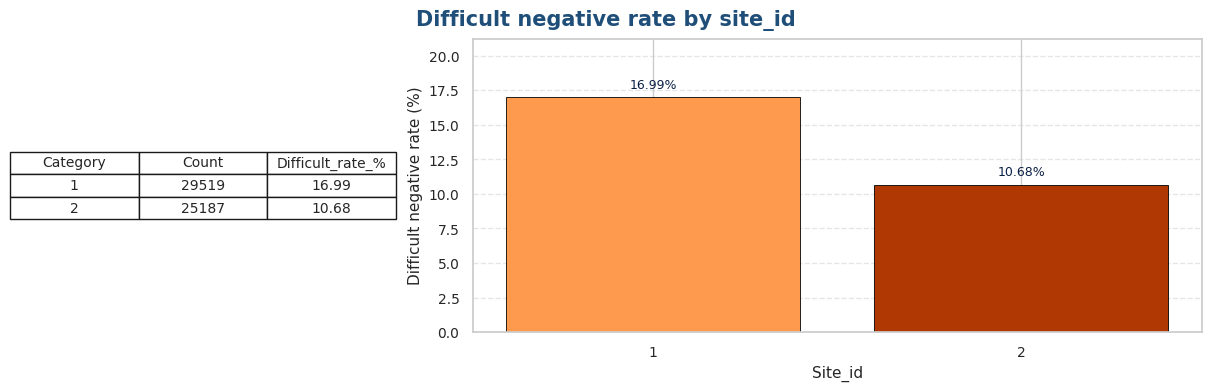

[site_id] Chi-square: χ²=445.48, dof=1, p-value=6.955e-99 → SIGNIFICANT at α=0.05


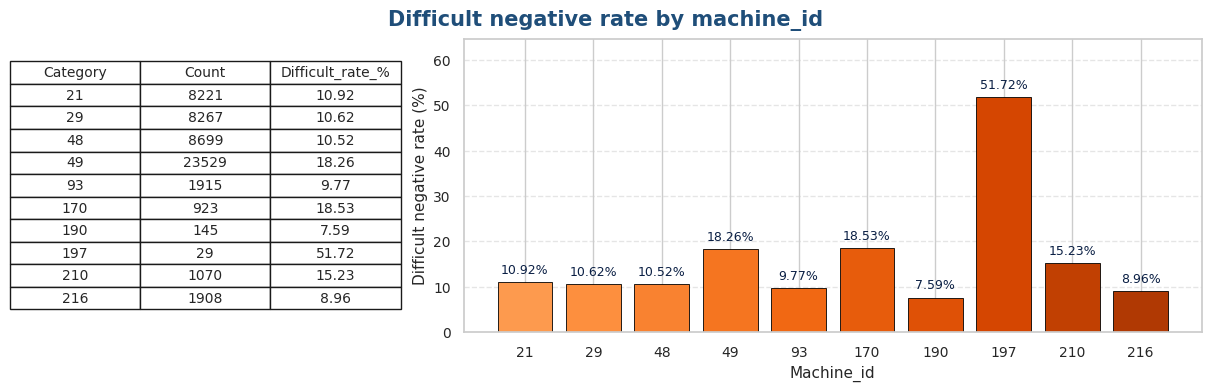

[machine_id] Chi-square: χ²=706.15, dof=9, p-value=3.289e-146 → SIGNIFICANT at α=0.05


In [27]:
# 1.6.4 : Cross-analysis of difficult_negative_case

def plot_cat_difficult_rate(df, col, order=None, title=None):
    """
    For a categorical variable (e.g., site_id or machine_id):
      - show table (Count, Difficult_rate_%)
      - show bar chart of difficult_negative_case rate per category
      - run Chi-square test of independence
      - print whether the association is statistically significant
    """
    counts = df[col].value_counts()
    if order is not None:
        counts = counts.reindex([c for c in order if c in counts.index])
    else:
        counts = counts.sort_index()

    # difficult_negative_case rate per category
    grp = df.groupby(col)["difficult_negative_case"].mean().reindex(counts.index)
    rate_pct = (grp * 100).round(2)

    summary = pd.DataFrame({
        "Category": counts.index.astype(str),
        "Count": counts.values,
        "Difficult_rate_%": rate_pct.values
    })

    # contingency table and chi-square
    contingency = pd.crosstab(df[col], df["difficult_negative_case"]).reindex(counts.index).fillna(0).values
    chi2, pval, dof, _ = chi2_contingency(contingency)

    # --- Figure: table + bar chart ---
    fig, (ax0, ax1) = plt.subplots(
        1, 2, figsize=(12, 3.8),
        gridspec_kw={"width_ratios": [1.3, 2.7]},
        constrained_layout=True
    )
    fig.suptitle(title or f"Difficult negative rate by {col}", fontsize=15, fontweight="bold", color="#1f4e79")

    ax0.axis("off")
    tbl = ax0.table(cellText=summary.values, colLabels=summary.columns,
                    cellLoc="center", loc="center")
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(10)
    tbl.scale(1.1, 1.35)

    colors = cm.Oranges(np.linspace(0.45, 0.85, len(summary)))
    bars = ax1.bar(summary["Category"], summary["Difficult_rate_%"],
                   color=colors, edgecolor="black", linewidth=0.6)
    ax1.set_ylabel("Difficult negative rate (%)", fontsize=11)
    ax1.set_xlabel(col.capitalize(), fontsize=11)
    ax1.tick_params(axis="both", labelsize=10)
    ax1.grid(axis="y", linestyle="--", alpha=0.5)

    ymax = max(0.1, float(summary["Difficult_rate_%"].max()) * 1.25)
    ax1.set_ylim(0, ymax)
    for i, b in enumerate(bars):
        ax1.text(b.get_x() + b.get_width()/2, b.get_height() + ymax*0.02,
                 f"{summary['Difficult_rate_%'][i]}%",
                 ha="center", va="bottom", fontsize=9, color="#0a1f44")
    plt.show()

    # Significance report
    signif = "SIGNIFICANT" if pval < ALPHA else "NOT significant"
    print(f"[{col}] Chi-square: χ²={chi2:.2f}, dof={dof}, p-value={pval:.3e} → {signif} at α={ALPHA}")

    return summary, {"chi2": chi2, "pval": pval, "dof": dof, "significant": pval < ALPHA}

# --- Run cross-analyses ---
order_site    = sorted(df["site_id"].dropna().unique().tolist())
order_machine = sorted(df["machine_id"].dropna().unique().tolist())

_ = plot_cat_difficult_rate(df, "site_id", order=order_site, title="Difficult negative rate by site_id")
_ = plot_cat_difficult_rate(df, "machine_id", order=order_machine, title="Difficult negative rate by machine_id")

The analysis reveals strong heterogeneity in the distribution of difficult negative cases across both sites and machines.
Site 1 shows a markedly higher proportion (≈ 17%) than Site 2 (≈ 11%), with a Chi-square test confirming a highly significant association (p < 10⁻⁹⁸).
Similarly, the distribution by machine_id varies widely — from below 10% on some machines up to ≈ 52% on machine 197 — again statistically significant (p < 10⁻¹⁴⁵).

These results indicate that the labeling of difficult negatives is not uniform across acquisition sources, suggesting potential site- or device-specific biases that should be considered when stratifying data or training the model.

# 2) Data Preprocessing

## 2.1 Data Cleaning
- Handle missing values for density
- Remove implants
- Remove duplicated images

In [28]:
# 2.1.1 Missing Density Analysis: Cancer cases among missing values

# Image-level analysis
missing_density_df = df[df["density"].isna()]
total_missing = len(missing_density_df)
cancer_missing = missing_density_df["cancer"].sum()

# Overall context
total_images = len(df)
total_cancer_images = df["cancer"].sum()

print("=== Missing Density Analysis (Image Level) ===")
print(f"Total images: {total_images:,}")
print(f"Total cancer images: {total_cancer_images:,} ({total_cancer_images / total_images * 100:.2f}%)")
print(f"\nImages with missing density: {total_missing:,} ({total_missing / total_images * 100:.2f}%)")
print(f"Cancer images among them: {cancer_missing:,} ({cancer_missing / total_missing * 100:.2f}%)")
print(f"→ Proportion of all cancer images that are missing density: {cancer_missing / total_cancer_images * 100:.2f}%")

# Patient-level analysis
missing_density_patients = (
    df.loc[df["density"].isna()]
    .groupby("patient_id")["cancer"]
    .max()   # 1 if any image of the patient is positive
    .reset_index()
)

total_patients_missing = len(missing_density_patients)
cancer_patients_missing = missing_density_patients["cancer"].sum()

# For global context (total patients)
total_patients = df["patient_id"].nunique()
cancer_patients_total = (
    df.groupby("patient_id")["cancer"].max().sum()
)

print("\n=== Missing Density Analysis (Patient Level) ===")
print(f"Total patients: {total_patients:,}")
print(f"Total cancer patients: {cancer_patients_total:,} ({cancer_patients_total / total_patients * 100:.2f}%)")
print(f"\nPatients with missing density: {total_patients_missing:,} ({total_patients_missing / total_patients * 100:.2f}%)")
print(f"Cancer patients among them: {cancer_patients_missing:,} ({cancer_patients_missing / total_patients_missing * 100:.2f}%)")
print(f"→ Proportion of all cancer patients that are missing density: {cancer_patients_missing / cancer_patients_total * 100:.2f}%")

=== Missing Density Analysis (Image Level) ===
Total images: 54,706
Total cancer images: 1,158 (2.12%)

Images with missing density: 25,236 (46.13%)
Cancer images among them: 494 (1.96%)
→ Proportion of all cancer images that are missing density: 42.66%

=== Missing Density Analysis (Patient Level) ===
Total patients: 11,913
Total cancer patients: 486 (4.08%)

Patients with missing density: 6,104 (51.24%)
Cancer patients among them: 234 (3.83%)
→ Proportion of all cancer patients that are missing density: 48.15%


In [29]:
# 2.1.2 Remove implants (rows where implant == 1)
df_step1 = df.copy()

before = len(df)

# Comptage des implants et des cancéreux parmi eux
n_implants = (df_step1["implant"] == 1).sum()
n_implants_cancer = df_step1[(df_step1["implant"] == 1) & (df_step1["cancer"] == 1)].shape[0]

# Suppression des lignes avec implant == 1
df_step1 = df_step1[df_step1["implant"] != 1].reset_index(drop=True)
after = len(df_step1)

# Résumé
print("Remove Implants: Filter out rows where implant == 1")
print(f"\tTotal rows before: {before}")
print(f"\tNumber of rows with implants (implant == 1): {n_implants}")
print(f"\tNumber of cancer cases among implants: {n_implants_cancer}")
print(f"\tProportion of cancer among implants: {n_implants_cancer / n_implants:.2%}")
print(f"\tTotal rows after: {after}")

Remove Implants: Filter out rows where implant == 1
	Total rows before: 54706
	Number of rows with implants (implant == 1): 1477
	Number of cancer cases among implants: 13
	Proportion of cancer among implants: 0.88%
	Total rows after: 53229


In [30]:
# 2.1.3 Remove duplicates — one image per (patient_id, laterality, view)
df_step2 = df_step1.copy()

# Count duplicates before removal
n_dups = df_step2.duplicated(subset=["patient_id", "laterality", "view"], keep=False).sum()
print(f"\tNumber of duplicated combinations before removal: {n_dups}")

	Number of duplicated combinations before removal: 12071


In [31]:
# Sort and drop duplicates
df_step2 = (
    df_step2
    .sort_values(["patient_id", "laterality", "view", "image_id"])
    .drop_duplicates(subset=["patient_id", "laterality", "view"], keep="first")
    .reset_index(drop=True)
)

print("Duplicate Removal: One image per (patient_id, laterality, view)")
print(f"\tRows before: {len(df_step1)}")
print(f"\tRows after:  {len(df_step2)}")
print(f"\tRemoved:     {len(df_step1) - len(df_step2)} "
      f"({(len(df_step1) - len(df_step2)) / len(df_step1) * 100:.2f}%)")

Duplicate Removal: One image per (patient_id, laterality, view)
	Rows before: 53229
	Rows after:  47004
	Removed:     6225 (11.69%)


Some patients have multiple DICOM images for the same breast and view combination (e.g., repeated CC or MLO captures).
To avoid data redundancy and potential overfitting, only one image per (patient_id, laterality, view) was retained.
This ensures that each breast and view pair is represented once, maintaining dataset consistency while reducing duplication bias.

In [32]:
# 2.1.4 : Age imputation using the median
median_age = df_step2["age"].median()
df_step2["age"] = df_step2["age"].fillna(median_age)

print(f"Median age used for imputation: {median_age:.1f}")
print(f"Missing values remaining after imputation: {df_step2['age'].isna().sum()}")

Median age used for imputation: 59.0
Missing values remaining after imputation: 0


## 2.2 Subsampling
- Stratified sampling of negative patients
- Preserve class distribution

We kept all cancer patients and randomly sampled 25% of non-cancer patients.
Sampling was done at the patient level to keep all images from the same person together.
We used stratified sampling across key variables: site_id, machine_id, density, difficult_negative_case, and age bins (based on fixed quantiles).
This ensures the subset preserves the same statistical structure as the full dataset.
All cancer cases remain, while non-cancers were reduced proportionally per stratum.
After subsampling: ~3.3k patients (483 cancers) and ~13k images total.
The cancer rate increased from 2% → 7% (images), improving class balance for training.
Distributions across sites, machines, and ages stayed within ±2% of the original.
The final subset (df_sub) is smaller, balanced, and statistically representative of the full dataset.

In [33]:
np.random.seed(RANDOM_SEED)

# 0) Patient-level table + BEFORE summary

patient_level = (
    df_step2.groupby("patient_id")
    .agg({
        "cancer": "max",
        "site_id": "first",
        "machine_id": "first",
        "age": "mean",
        "density": "first",
        "difficult_negative_case": "max"
    })
    .reset_index()
)

# Prep for stratification
# Density: create a group with explicit 'MISSING'
patient_level["density_grp"] = patient_level["density"].astype(object)
patient_level["density_grp"] = patient_level["density_grp"].where(
    patient_level["density_grp"].notna(), "MISSING"
)

# Difficult_negative_case: convert to binary (0/1)
patient_level["difficult_negative_case_grp"] = (
    patient_level["difficult_negative_case"].fillna(0).astype(int)
)

# Age: create fixed quantile bins for stratification
age_bins = pd.qcut(patient_level["age"], q=5, duplicates="drop").cat.categories
patient_level["age_bin"] = pd.cut(patient_level["age"], bins=age_bins, include_lowest=True)

# BEFORE summary
pts_total_before = len(patient_level)
pts_pos_before   = int(patient_level["cancer"].sum())
pts_neg_before   = pts_total_before - pts_pos_before

imgs_total_before = len(df_step2)
imgs_pos_before   = int(df_step2["cancer"].sum())
imgs_neg_before   = imgs_total_before - imgs_pos_before

print("=== BEFORE (full dataset) ===")
print(f"Patients  | total={pts_total_before:,}  pos={pts_pos_before:,}  neg={pts_neg_before:,}  pos_rate={pts_pos_before/pts_total_before:.2%}")
print(f"Images    | total={imgs_total_before:,}  pos={imgs_pos_before:,}  neg={imgs_neg_before:,}  pos_rate={imgs_pos_before/imgs_total_before:.2%}")

# 1) Split cancer vs NON-cancer patients
pos_patients = patient_level[patient_level["cancer"] == 1].copy()
neg_patients = patient_level[patient_level["cancer"] == 0].copy()

# 2) Stratified proportional sampling of NON-cancer patients
#    Strata = site_id × machine_id × density_grp × difficult_negative_case_grp × age_bin
group_cols = ["site_id", "machine_id", "density_grp", "difficult_negative_case_grp", "age_bin"]
selected_negatives = []

for keys, g in neg_patients.groupby(group_cols, dropna=False):
    n = len(g)
    if n == 0:
        continue
    n_keep = int(round(n * NEG_FRACTION))
    n_keep = max(1, min(n_keep, n))  # ensure at least 1 per stratum
    sampled_ids = np.random.choice(g["patient_id"].values, size=n_keep, replace=False)
    selected_negatives.extend(sampled_ids)

# 3) Combine with ALL cancer patients → df_sub
selected_patients = np.concatenate([pos_patients["patient_id"].values, selected_negatives])
df_sub = df_step2[df_step2["patient_id"].isin(selected_patients)].reset_index(drop=True)

# 4) AFTER summary (patients & images)
# Patient-level AFTER
sub_patient_level = df_sub.groupby("patient_id")["cancer"].max().reset_index()
pts_total_after = len(sub_patient_level)
pts_pos_after   = int(sub_patient_level["cancer"].sum())
pts_neg_after   = pts_total_after - pts_pos_after

# Image-level AFTER
imgs_total_after = len(df_sub)
imgs_pos_after   = int(df_sub["cancer"].sum())
imgs_neg_after   = imgs_total_after - imgs_pos_after

print("\n=== AFTER (reduced, representative subset) ===")
print(f"Patients  | total={pts_total_after:,}  pos={pts_pos_after:,}  neg={pts_neg_after:,}  pos_rate={pts_pos_after/pts_total_after:.2%}")
print(f"Images    | total={imgs_total_after:,}  pos={imgs_pos_after:,}  neg={imgs_neg_after:,}  pos_rate={imgs_pos_after/imgs_total_after:.2%}")

# df_sub : final reduced dataframe

=== BEFORE (full dataset) ===
Patients  | total=11,742  pos=483  neg=11,259  pos_rate=4.11%
Images    | total=47,004  pos=979  neg=46,025  pos_rate=2.08%

=== AFTER (reduced, representative subset) ===
Patients  | total=3,344  pos=483  neg=2,861  pos_rate=14.44%
Images    | total=13,379  pos=979  neg=12,400  pos_rate=7.32%


In [ ]:
# 5) Distribution sanity checks (aligned with subset creation)

def prop(table, col, name):
    """Return normalized proportions of a column."""
    return table[col].value_counts(normalize=True, dropna=False).sort_index().rename(name)

# Original patient-level distributions
orig = patient_level.copy()
orig["density_check"] = orig["density_grp"]
orig["difficult_negative_case_grp"] = orig["difficult_negative_case_grp"]

# Subsampled patient-level distributions
sub = (
    df_sub.groupby("patient_id")
          .agg({
              "site_id": "first",
              "machine_id": "first",
              "density": "first",
              "difficult_negative_case": "max",
              "age": "mean"
          }).reset_index()
)
sub["density_check"] = sub["density"].where(sub["density"].notna(), "MISSING")
sub["difficult_negative_case_grp"] = sub["difficult_negative_case"].fillna(0).astype(int)

# Compare categorical variables
for col in ["site_id", "machine_id", "density_check", "difficult_negative_case_grp"]:
    comp = pd.concat(
        [prop(orig, col, "original"), prop(sub, col, "subsample")],
        axis=1
    ).fillna(0)
    print(f"\n--- {col} distribution: original vs subsample ---\n{comp}")

# AGE BINS COMPARISON
# Use the same age_bins computed during subsampling
orig_age_bins = pd.cut(patient_level["age"], bins=age_bins, include_lowest=True)
sub_age_bins  = pd.cut(sub["age"],           bins=age_bins, include_lowest=True)

# Compare age distributions using the same bins
age_comp = pd.concat([
    orig_age_bins.value_counts(normalize=True).rename("original"),
    sub_age_bins.value_counts(normalize=True).rename("subsample")
], axis=1).fillna(0).sort_index()

print("\n--- age quantile bins (original vs subsample, FIXED BINS) ---")
print(age_comp)


--- site_id distribution: original vs subsample ---
         original  subsample
site_id                     
1        0.480923   0.491926
2        0.519077   0.508074

--- machine_id distribution: original vs subsample ---
            original  subsample
machine_id                     
21          0.170329   0.166268
29          0.172117   0.168062
48          0.176631   0.173744
49          0.377534   0.383971
93          0.033044   0.031998
170         0.014989   0.018541
190         0.002214   0.004187
197         0.000341   0.001196
210         0.019928   0.020335
216         0.032873   0.031699

--- density_check distribution: original vs subsample ---
               original  subsample
density_check                     
A              0.046244   0.047847
B              0.209504   0.212022
C              0.198944   0.202751
D              0.025634   0.028409
MISSING        0.519673   0.508971

--- difficult_negative_case_grp distribution: original vs subsample ---
              

In [35]:
# Basic cancer vs non-cancer summary (patients & images)

# ---- Patient-level counts ----
patient_summary = (
    df_sub.groupby("patient_id")["cancer"].max().value_counts().rename({0: "non_cancer", 1: "cancer"})
)
n_patients_total = df_sub["patient_id"].nunique()

# ---- Image-level counts ----
image_summary = df_sub["cancer"].value_counts().rename({0: "non_cancer", 1: "cancer"})
n_images_total = len(df_sub)

print("=== Cancer vs Non-Cancer Summary ===")
print(f"Patients total: {n_patients_total:,}")
print(f"  • Cancer patients:     {patient_summary.get('cancer', 0):,}")
print(f"  • Non-cancer patients: {patient_summary.get('non_cancer', 0):,}")
print(f"  → Cancer rate (patients): {patient_summary.get('cancer', 0) / n_patients_total:.2%}")

print(f"\nImages total: {n_images_total:,}")
print(f"  • Cancer images:     {image_summary.get('cancer', 0):,}")
print(f"  • Non-cancer images: {image_summary.get('non_cancer', 0):,}")
print(f"  → Cancer rate (images): {image_summary.get('cancer', 0) / n_images_total:.2%}")

=== Cancer vs Non-Cancer Summary ===
Patients total: 3,344
  • Cancer patients:     483
  • Non-cancer patients: 2,861
  → Cancer rate (patients): 14.44%

Images total: 13,379
  • Cancer images:     979
  • Non-cancer images: 12,400
  → Cancer rate (images): 7.32%


In [36]:
# 1) Columns to keep
cols_final = [
    "site_id","patient_id","image_id","laterality","view",
    "age","density","machine_id","cancer"
]

# 2) Build df_final from df_sub
df_final = df_sub[cols_final].copy()

# 3) Replace missing density with "N"
from pandas.api.types import is_categorical_dtype
if is_categorical_dtype(df_final["density"]):
    df_final["density"] = (
        df_final["density"]
        .cat.add_categories(["N"])
        .fillna("N")
    )
else:
    df_final["density"] = (
        df_final["density"]
        .replace("", pd.NA)
        .fillna("N")
        .astype(str)
    )
print("Missing density values replaced with 'N'")
print(df_final["density"].value_counts(dropna=False))

Missing density values replaced with 'N'
density
N    6808
B    2837
C    2714
A     640
D     380
Name: count, dtype: int64


## 2.3 Dataset Splitting
- Create train, validation and test sets
- No patient leakage across splits
- Stratified by patient-level cancer

In [ ]:
# Train/Val/Test split (70/15/15) by patient_id

# 1) Patient-level table on df_final
patient_level_final = (
    df_final.groupby("patient_id")
          .agg(cancer=("cancer", "max"))
          .reset_index()
)
print("Patients in df_final:", len(patient_level_final))
print("Cancer patients in df_final:", int(patient_level_final["cancer"].sum()))

# 2) Split patients -> 70% train, 30% temp (stratified by cancer)
train_pat, temp_pat = train_test_split(
    patient_level_final["patient_id"],
    test_size=0.30,
    random_state=RANDOM_SEED,
    stratify=patient_level_final["cancer"]
)

# 3) Split temp -> 15% val, 15% test (half/half of temp, stratified)
temp_df = patient_level_final[patient_level_final["patient_id"].isin(temp_pat)]
val_pat, test_pat = train_test_split(
    temp_df["patient_id"],
    test_size=0.50,
    random_state=RANDOM_SEED,
    stratify=temp_df["cancer"]
)

# 4) Assign splits to df_final (CHANGÉ ICI)
df_final["split"] = "train"
df_final.loc[df_final["patient_id"].isin(val_pat),  "split"] = "val"
df_final.loc[df_final["patient_id"].isin(test_pat), "split"] = "test"

# 5) Safety checks: no patient overlap
assert set(train_pat).isdisjoint(set(val_pat))
assert set(train_pat).isdisjoint(set(test_pat))
assert set(val_pat).isdisjoint(set(test_pat))

# 6) Summaries
def patient_summary(d):
    pl = d.groupby("patient_id")["cancer"].max()
    return pd.Series({
        "patients": len(pl),
        "cancer_patients": int(pl.sum()),
        "cancer_rate_patients": pl.mean()
    })

def image_summary(d):
    return pd.Series({
        "images": len(d),
        "cancer_images": int(d["cancer"].sum()),
        "cancer_rate_images": d["cancer"].mean()
    })

print("\n=== Patient-level summary per split ===")
print(df_final.groupby("split").apply(patient_summary).round(4))

print("\n=== Image-level summary per split ===")
print(df_final.groupby("split").apply(image_summary).round(4))

Patients in df_final: 3344
Cancer patients in df_final: 483

=== Patient-level summary per split ===
       patients  cancer_patients  cancer_rate_patients
split                                                 
test      502.0             72.0                0.1434
train    2340.0            338.0                0.1444
val       502.0             73.0                0.1454

=== Image-level summary per split ===
       images  cancer_images  cancer_rate_images
split                                           
test   2008.0          144.0              0.0717
train  9363.0          685.0              0.0732
val    2008.0          150.0              0.0747


Overlap train/val:  0
Overlap train/test: 0
Overlap val/test:   0

=== site_id distribution per split ===


split,test,train,val
site_id,,,
1,0.492,0.497,0.47
2,0.508,0.503,0.53



=== machine_id distribution per split ===


split,test,train,val
machine_id,,,
21,0.177,0.162,0.173
29,0.175,0.171,0.147
48,0.155,0.170,0.209
49,0.390,0.384,0.376
93,0.034,0.034,0.021
170,0.012,0.019,0.022
190,0.002,0.006,0.000
197,0.002,0.001,0.002
210,0.010,0.021,0.026



=== density distribution per split ===


split,test,train,val
density,,,
A,0.056,0.049,0.036
B,0.223,0.214,0.191
C,0.191,0.201,0.221
D,0.020,0.032,0.022
N,0.510,0.504,0.530


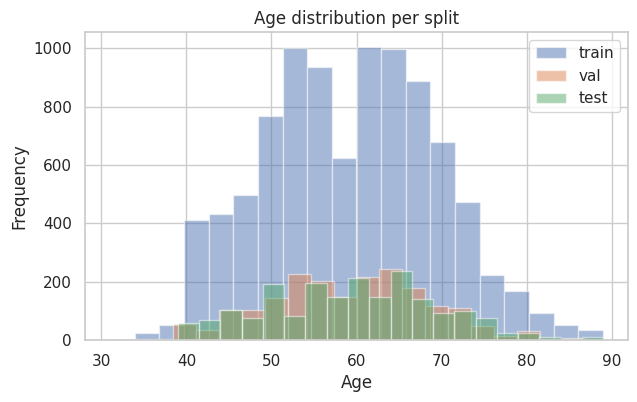

split
test     0.072
train    0.073
val      0.075
Name: cancer, dtype: float64


In [38]:
# Check for patient leakage
sets = {s: set(df_final.loc[df_final["split"] == s, "patient_id"]) for s in ["train", "val", "test"]}
overlap_train_val  = sets["train"].intersection(sets["val"])
overlap_train_test = sets["train"].intersection(sets["test"])
overlap_val_test   = sets["val"].intersection(sets["test"])
print(f"Overlap train/val:  {len(overlap_train_val)}")
print(f"Overlap train/test: {len(overlap_train_test)}")
print(f"Overlap val/test:   {len(overlap_val_test)}")

# Check stratification balance across splits
def prop(df, col):
    return df[col].value_counts(normalize=True).rename_axis(col).reset_index(name="proportion")

for col in ["site_id", "machine_id", "density"]:
    print(f"\n=== {col} distribution per split ===")
    display(
        df_final.groupby("split")
              .apply(lambda d: prop(d, col))
              .reset_index(level=0)
              .pivot(index=col, columns="split", values="proportion")
              .fillna(0)
              .round(3)
    )

# Check age distributions
plt.figure(figsize=(7,4))
for split, color in zip(["train", "val", "test"], ["blue", "orange", "green"]):
    df_final.loc[df_final["split"] == split, "age"].hist(alpha=0.5, bins=20, label=split)
plt.legend()
plt.title("Age distribution per split")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()
print(df_final.groupby("split")["cancer"].mean().round(3))

All quality checks confirm that the dataset split is correct and unbiased.
No patient appears in multiple splits (zero overlap across train/val/test).
The distributions of key variables (site_id, machine_id, density) are consistent across splits, with no significant deviations.
Age distributions are well aligned, showing similar shapes and ranges in all subsets.
Cancer prevalence remains stable (~7%) across train, validation, and test.
Overall, the split is clean, stratified, and statistically representative, ensuring no data leakage and balanced evaluation.

In [39]:
output_path = "df_final.csv"
df_final.to_csv(output_path, index=False)
print(f"CSV saved to: {output_path}")

# Split df_final into X_train, Y_train, X_val, Y_val, X_test, Y_test
df_train = df_final[df_final["split"] == "train"].reset_index(drop=True)
df_val   = df_final[df_final["split"] == "val"].reset_index(drop=True)
df_test  = df_final[df_final["split"] == "test"].reset_index(drop=True)

# Define feature columns (exclude target + split)
feature_cols = [
    "site_id",
    "patient_id",
    "image_id",
    "laterality",
    "view",
    "age",
    "density",
    "machine_id"
]
target_col = "cancer"

# Separate X (features) and y (target)
X_train, Y_train = df_train[feature_cols].copy(), df_train[target_col].copy()
X_val,   Y_val   = df_val[feature_cols].copy(),   df_val[target_col].copy()
X_test,  Y_test  = df_test[feature_cols].copy(),  df_test[target_col].copy()

# Quick sanity check
print("=== Dataset sizes ===")
print(f"Train: X={X_train.shape}, y={Y_train.shape}")
print(f"Val:   X={X_val.shape}, y={Y_val.shape}")
print(f"Test:  X={X_test.shape}, y={Y_test.shape}")

CSV saved to: df_final.csv
=== Dataset sizes ===
Train: X=(9363, 8), y=(9363,)
Val:   X=(2008, 8), y=(2008,)
Test:  X=(2008, 8), y=(2008,)


In [40]:
# All files will be saved in the current working directory: /kaggle/working/
# They will appear automatically under "Output Files" after the notebook finishes running.

# Save feature sets
X_train.to_csv("X_train.csv", index=False)
X_val.to_csv("X_val.csv", index=False)
X_test.to_csv("X_test.csv", index=False)

# Save target sets
Y_train.to_csv("Y_train.csv", index=False)
Y_val.to_csv("Y_val.csv", index=False)
Y_test.to_csv("Y_test.csv", index=False)

# Confirmation
print("\nCSV files saved successfully to /kaggle/working/")
print("Saved files:")
for f in ["X_train.csv", "Y_train.csv", "X_val.csv", "Y_val.csv", "X_test.csv", "Y_test.csv"]:
    print(" •", f)


CSV files saved successfully to /kaggle/working/
Saved files:
 • X_train.csv
 • Y_train.csv
 • X_val.csv
 • Y_val.csv
 • X_test.csv
 • Y_test.csv


In [ ]:
# Load all dataframes
df = pd.read_csv("/kaggle/input/rsna-breast-cancer-detection/train.csv")
df_final = pd.read_csv("df_final.csv")
X_train = pd.read_csv("X_train.csv")
Y_train = pd.read_csv("Y_train.csv")
X_val = pd.read_csv("X_val.csv")
Y_val = pd.read_csv("Y_val.csv")
X_test = pd.read_csv("X_test.csv")
Y_test = pd.read_csv("Y_test.csv")

# Function to calculate stats
def calculate_stats(X_df, y_df=None, df_combined=None):
    """
    X_df: features dataframe (with patient_id)
    y_df: target dataframe (with cancer column) - optional
    df_combined: if it's a complete df with both features and target
    """
    if df_combined is not None:
        # For df and df_final (complete dataframes)
        nb_patients = df_combined["patient_id"].nunique()
        nb_patients_cancer = df_combined.groupby("patient_id")["cancer"].max().sum()
        nb_images = len(df_combined)
        nb_images_cancer = df_combined["cancer"].sum()
    else:
        # For split datasets (X and y separate)
        nb_patients = X_df["patient_id"].nunique()
        nb_patients_cancer = X_df.groupby("patient_id").apply(
            lambda x: y_df.loc[x.index, "cancer"].max()
        ).sum()
        nb_images = len(X_df)
        nb_images_cancer = y_df["cancer"].sum()

    return {
        "nb_patients": int(nb_patients),
        "nb_patients_cancer": int(nb_patients_cancer),
        "nb_images_total": int(nb_images),
        "nb_images_cancer": int(nb_images_cancer)
    }

# Calculate size for df_final splits
def calculate_size_for_patients(patient_ids, train_images_path):
    """Calculate total size for a list of patient_ids"""
    total_size = 0
    for patient_id in patient_ids:
        patient_folder = str(patient_id)
        patient_path = os.path.join(train_images_path, patient_folder)
        if os.path.exists(patient_path):
            for image_file in os.listdir(patient_path):
                if image_file.endswith('.dcm'):
                    image_path = os.path.join(patient_path, image_file)
                    total_size += os.path.getsize(image_path)
    return total_size / (1024 ** 3)  # Convert to GB

# Path to images
train_images_path = "/kaggle/input/rsna-breast-cancer-detection/train_images"

# Build stats dictionary
stats = {}

# 1. df (initial)
print("Calculating stats for df (initial)...")
stats["df_initial"] = calculate_stats(None, None, df)
# Size for df_initial = all images in train_images
total_size_initial = 0
for patient_folder in os.listdir(train_images_path):
    patient_path = os.path.join(train_images_path, patient_folder)
    for image_file in os.listdir(patient_path):
        if image_file.endswith('.dcm'):
            total_size_initial += os.path.getsize(os.path.join(patient_path, image_file))
stats["df_initial"]["size_GB"] = round(total_size_initial / (1024 ** 3), 2)

# 2. df_final (cleaned)
print("Calculating stats for df_final...")
stats["df_final"] = calculate_stats(None, None, df_final)
stats["df_final"]["size_GB"] = 82.87  # Already calculated

# 3. Train
print("Calculating stats for train...")
stats["train"] = calculate_stats(X_train, Y_train)
train_patients = X_train["patient_id"].unique()
stats["train"]["size_GB"] = round(calculate_size_for_patients(train_patients, train_images_path), 2)

# 4. Val
print("Calculating stats for val...")
stats["val"] = calculate_stats(X_val, Y_val)
val_patients = X_val["patient_id"].unique()
stats["val"]["size_GB"] = round(calculate_size_for_patients(val_patients, train_images_path), 2)

# 5. Test
print("Calculating stats for test...")
stats["test"] = calculate_stats(X_test, Y_test)
test_patients = X_test["patient_id"].unique()
stats["test"]["size_GB"] = round(calculate_size_for_patients(test_patients, train_images_path), 2)

# Create summary dataframe
summary_df = pd.DataFrame(stats).T
summary_df.index.name = "Dataset"
summary_df = summary_df.reset_index()

# Reorder columns
summary_df = summary_df[[
    "Dataset",
    "nb_patients",
    "nb_patients_cancer",
    "nb_images_total",
    "nb_images_cancer",
    "size_GB"
]]

# Add percentage columns
summary_df["cancer_rate_patients_%"] = round(
    (summary_df["nb_patients_cancer"] / summary_df["nb_patients"]) * 100, 2
)
summary_df["cancer_rate_images_%"] = round(
    (summary_df["nb_images_cancer"] / summary_df["nb_images_total"]) * 100, 2
)

# Display
print("\n" + "="*80)
print("COMPLETE SUMMARY TABLE")
print("="*80)
display(summary_df)

Calculating stats for df (initial)...
Calculating stats for df_final...
Calculating stats for train...
Calculating stats for val...
Calculating stats for test...

COMPLETE SUMMARY TABLE


,Dataset,nb_patients,nb_patients_cancer,nb_images_total,nb_images_cancer,size_GB,cancer_rate_patients_%,cancer_rate_images_%
0,df_initial,11913.0,486.0,54706.0,1158.0,293.10,4.08,2.12
1,df_final,3344.0,483.0,13379.0,979.0,82.87,14.44,7.32
2,train,2340.0,338.0,9363.0,685.0,57.99,14.44,7.32
3,val,502.0,73.0,2008.0,150.0,12.35,14.54,7.47
4,test,502.0,72.0,2008.0,144.0,12.52,14.34,7.17


# Conclusion 

In this exploratory analysis, we conducted a thorough examination of the RSNA Breast Cancer Detection dataset to understand its structure, quality, and main statistical properties before moving on to modeling.

We first verified the consistency of the dataset, confirming that each image, patient, and identifier was properly matched and that the overall organization was coherent. During the initial checks, we detected some missing values in key variables such as BIRADS, density, and age, which were handled appropriately during data cleaning.

The dataset also exhibited a strong class imbalance, with far fewer positive (cancer) cases than negative ones. To facilitate exploration while maintaining statistical validity, we implemented a rigorous resampling procedure to create a smaller but representative subset of the data. This resampling carefully preserved the original distributions across all relevant variables — including age, laterality, view, density, and site — ensuring that any subsequent analysis remained faithful to the full dataset.

During our analysis, we identified a notable site and machine bias: certain imaging sites and machine types appeared to be unevenly distributed across classes. This suggests that technical or institutional differences might influence image characteristics or even correlate with the target variable. Such biases will need to be carefully addressed during model training to avoid data leakage and ensure fair generalization.

We also observed:
- Subtle age-related patterns in cancer prevalence.
- Balanced distributions of laterality (left/right) and view type (CC/MLO).
- Distinct patterns in breast density, which could affect both model interpretability and detection performance.

After cleaning, handling missing data, and resampling, we generated train, validation, and test splits based on the representative subset.
Finally, the processed datasets have been exported as .csv files, ready to be imported into the final modeling notebook, where we will perform model training, validation, and evaluation leveraging the insights gained in this EDA.